In [1]:
import os
import tensorflow as tf
from tensorflow.python.platform import gfile
import tensorflow.contrib.slim
import sklearn
import numpy as np
from scipy import stats
import pandas as pd
import librosa
import pickle
import math
import matplotlib.pyplot as plt
from librosa import display
from collections import Counter
%matplotlib inline

In [2]:
def compute_features(tids):
    successful_tids = []
    successful_features = []
    for tid in tids:
        try:
            filepath = get_audio_path('dataset/audio', tid)

            try:
                ### do not change here !
                x, sr = librosa.load(filepath, sr=44100, mono=True, duration=20)
                x = x.tolist()

                new_x = []
                while len(new_x) < 44100 * 20:
                    new_x.extend(x)
                new_x = new_x[:44100 * 20]
                x = np.array(new_x)
                ###
                front_x = x[:2205]
                end_x = x[41895:]
                x = np.append(front_x, x)
                x = np.append(x, end_x)

                hop_length=512
                timeseries_length = 18
                for i in range(200):
                    data = np.zeros((40, timeseries_length), dtype=np.float64)
                    mini_x = x[i*4410:i*4410 + 8820]
                    stft = np.abs(librosa.stft(mini_x, n_fft=2048, hop_length=hop_length))
                    mel = librosa.feature.melspectrogram(sr=sr, S=stft ** 2)
                    del stft
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
                    spectral_center = librosa.feature.spectral_centroid(mini_x, sr=sr, hop_length=hop_length)
                    chroma = librosa.feature.chroma_stft(mini_x, sr=sr, hop_length=hop_length)
                    spectral_contrast = librosa.feature.spectral_contrast(mini_x, sr=sr, hop_length=hop_length)
                    data[0:20, :] = mfcc
                    data[20:21, :] = spectral_center
                    data[21:33, :] = chroma
                    data[33:40, :] = spectral_contrast
                    successful_tids.append(tid)
                    successful_features.append(data)

            except Exception as e:
                print(filepath, e)



        except Exception as e:
            print('{}: {}'.format(tid, repr(e)))

    return successful_tids, successful_features

def feature_examples(tid):
    # example of various librosa features
    # please check [https://librosa.github.io/librosa/feature.html]
    threshold = 1278900
    try:
        filepath = get_audio_path('dataset/audio', tid)
        ### do not change here !
        x, sr = librosa.load(filepath, sr=44100, mono=True, duration=20)
        x = x.tolist()
        origin_length = len(x)

        new_x = []
        while len(new_x) < 44100 * 20:
            new_x.extend(x)
        new_x = new_x[:44100 * 20]
        x = np.array(new_x)
        ###

        # zero_crossing_rate
        # returns (1,t)
        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)


        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7 * 12, tuning=None))
        assert cqt.shape[0] == 7 * 12
        assert np.ceil(len(x) / 512) <= cqt.shape[1] <= np.ceil(len(x) / 512) + 1

        # chroma_cqt
        # returns (n_chroma, t)
        f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)

        # chroma_cqt
        # returns (n_chroma, t)
        f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        assert stft.shape[0] == 1 + 2048 // 2
        assert np.ceil(len(x) / 512) <= stft.shape[1] <= np.ceil(len(x) / 512) + 1
        del x

        # chroma_stft
        # returns (n_chroma, t)
        f = librosa.feature.chroma_stft(S=stft ** 2, n_chroma=12)

        # rmse
        # returns (1,t)
        f = librosa.feature.rmse(S=stft)

        # spectral_centroid
        # returns (1,t)
        f = librosa.feature.spectral_centroid(S=stft)

        # spectral_bandwidth
        # returns (1,t)
        f = librosa.feature.spectral_bandwidth(S=stft)

        # spectral_contrast
        # returns (n_bands+1, t)
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)

        # spectral_rolloff
        # returns (1,t)
        f = librosa.feature.spectral_rolloff(S=stft)

        # mfcc
        # returns (n_mfcc, t)
        mel = librosa.feature.melspectrogram(sr=sr, S=stft ** 2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)

    except Exception as e:
        print('{}: {}'.format(tid, repr(e)))
        return tid, 0


def get_audio_path(audio_dir, track_id):
    return os.path.join(audio_dir, track_id + '.wav')

In [3]:
# fixed
meta_path = 'dataset/audio_list.csv'
label_path = 'dataset/labels.pkl'
val_set_number = 0

metadata_df = pd.read_csv(meta_path)
train_meta_df = metadata_df[metadata_df['set'] != val_set_number]
val_meta_df = metadata_df[metadata_df['set'] == val_set_number]
# metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
train_track_ids = train_meta_df['FileName'].values
val_track_ids = val_meta_df['FileName'].values

In [4]:
ids, features = compute_features(train_track_ids)
val_ids, val_features = compute_features(val_track_ids)
Xd = np.array(features)
Xd_val = np.array(val_features)
Xd.shape, Xd_val.shape

/home/lyusungwon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


((11600, 40, 18), (5800, 40, 18))

In [4]:
Xd = pickle.load(open('mix.pkl', 'rb'))
Xd_val = pickle.load(open('mix_val.pkl', 'rb'))
Xd.shape, Xd_val.shape

((11600, 40, 18), (5800, 40, 18))

In [12]:
Xd2 = np.reshape(Xd, (Xd.shape[0]//200, Xd.shape[1], Xd.shape[2]*200))
print(Xd2.shape)
Xd[1,:,:] == Xd2[0,:,:18:36]

(58, 40, 3600)


array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],

In [5]:
labels = pickle.load(open(label_path, 'rb'))

def get_labels(name_list):
    # get labels from label dictionary
    # [[list of hihats],[list of kicks], [list of snares],
    #   [list of hihats],[list of kicks], [list of snares]],...
#     print("name_list", name_list)
    label = []
    for x in name_list:
        label.append(labels[x])
    label = np.array(label)
    return label

def to_eight(onehot):
    hihat = onehot[:,0,:].flatten()
    kick = onehot[:,1,:].flatten()
    snare = onehot[:,2,:].flatten()
    n = onehot.shape[0]*onehot.shape[2]
    yd = np.zeros((n, 8))
    for i in range(n):
        if hihat[i] == 1 and kick[i] != 1 and snare[i] != 1:
            yd[i,1] = 1
        elif hihat[i] != 1 and kick[i] == 1 and snare[i] != 1:
            yd[i,2] = 1
        elif hihat[i] != 1 and kick[i] != 1 and snare[i] == 1:
            yd[i,3] = 1        
        elif hihat[i] == 1 and kick[i] == 1 and snare[i] != 1:
            yd[i,4] = 1
        elif hihat[i] == 1 and kick[i] != 1 and snare[i] == 1:
            yd[i,5] = 1
        elif hihat[i] != 1 and kick[i] == 1 and snare[i] == 1:
            yd[i,6] = 1
        elif hihat[i] == 1 and kick[i] == 1 and snare[i] == 1:
            yd[i,7] = 1     
        else:
            yd[i,0] = 1    
    return yd

yd = to_eight(np.array(get_labels(train_track_ids)))
yd_val = to_eight(np.array(get_labels(val_track_ids)))
yd.shape, yd_val.shape

((11600, 8), (5800, 8))

In [6]:
with open('mix.pkl', 'wb') as mixf:
    pickle.dump(Xd, mixf, protocol=pickle.HIGHEST_PROTOCOL)
with open('y.pkl', 'wb') as yf:
    pickle.dump(yd, yf, protocol=pickle.HIGHEST_PROTOCOL)
with open('mix_val.pkl', 'wb') as mix_valf:
    pickle.dump(Xd_val, mix_valf, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_val.pkl', 'wb') as y_valf:
    pickle.dump(yd_val, y_valf, protocol=pickle.HIGHEST_PROTOCOL)    

In [26]:
# Model for training and validation

tf.reset_default_graph()

n_input = 40 * 18
n_classs = 8
image_height = 40
image_width = 18
# fully-connected layer property
hidden1 = 1024
hidden2 = 1024
dropout_rate = 0.5
# convolutional layer property
conv_size = 3
n_filter1 = 64
n_filter2 = 128
n_filter3 = 256
# pooling layer property
pool_size = 2
# Placeholder and variables
# TODO : declare placeholder and variables

X = tf.placeholder(tf.float32, [None, image_height, image_width])
y = tf.placeholder(tf.int64, [None, n_classs])
is_training = tf.placeholder(tf.bool)

# Build model
# TODO : build your model here
# Model
def from_eight(y_preds):
    hihat = [0] * len(y_preds)
    kick = [0] * len(y_preds)
    snare = [0] * len(y_preds)
    for i in range(len(y_preds)):
        if y_preds[i, 1] == 1:
            hihat[i] = 1
        elif y_preds[i, 2] == 1:
            kick[i] = 1
        elif y_preds[i, 3] == 1:
            snare[i] = 1
        elif y_preds[i, 4] == 1:
            hihat[i] = 1
            kick[i] = 1
        elif y_preds[i, 5] == 1:
            hihat[i] = 1
            snare[i] = 1
        elif y_preds[i, 6] == 1:
            kick[i] = 1
            snare[i] = 1
        elif y_preds[i, 7] == 1:
            hihat[i] = 1
            kick[i] = 1
            snare[i] = 1
    return [hihat, kick, snare]

def onehot(y):
    yd = np.zeros_like(y)
    for n, i in enumerate(np.argmax(y, 1)):
        yd[n,i] = 1
    return yd        

def calculate_average_F1_score(pred_lists, label_lists):
    # calculate average F1 score (hihat, kick, snare)
    # shape of each list is 3*200
    avg_f1_score = 0
    for pred_list, label_list in zip(pred_lists, label_lists):
        counts = Counter(zip(pred_list, label_list))
        tp = counts[1,1]
        fp = counts[1,0]
        fn = counts[0,1]
        try:
            precision = tp / (tp+fp)
        except ZeroDivisionError:
            precision = 0

        try:
            recall = tp / (fn + tp)
        except ZeroDivisionError:
            recall = 0

        try:
            f1 = 2*(precision*recall / (precision+recall))
        except ZeroDivisionError:
            f1 = 0
        avg_f1_score+=f1

#         print(precision, recall, f1)

    avg_f1_score /= 3
    return avg_f1_score

def model(X,y,is_training):
    regularizer = tf.contrib.layers.l2_regularizer(1e-6)
    activation = tf.nn.elu
    init = tf.contrib.layers.xavier_initializer()
    
    x_reshaped = tf.reshape(X, [-1, image_height, image_width, 1])
    c11 = tf.layers.conv2d(x_reshaped, n_filter1, conv_size, 1, "same", activation = activation, kernel_initializer = init, kernel_regularizer = regularizer)
    c12 = tf.layers.conv2d(c11, n_filter1, conv_size, 1, "same", activation = activation, kernel_initializer = init, kernel_regularizer = regularizer)
    mp1 = tf.layers.max_pooling2d(c11, pool_size, 2,  "same")
    c21 = tf.layers.conv2d(mp1, n_filter2, conv_size, 1, "same", activation = activation, kernel_initializer = init, kernel_regularizer = regularizer)
    c22 = tf.layers.conv2d(c21, n_filter2, conv_size, 1, "same", activation = activation, kernel_initializer = init, kernel_regularizer = regularizer)
    mp2 = tf.layers.max_pooling2d(c21, pool_size, 2,  "same")
    c3 = tf.layers.conv2d(mp2, 1, 1, 1, "same", activation = activation, kernel_initializer = init, kernel_regularizer = regularizer)
    if is_training is not None:
        c3 = tf.nn.dropout(c3, dropout_rate) * dropout_rate
    flat = tf.reshape(c3, [-1, 50])

    w_fc1 = tf.get_variable("W_fc1", shape=[n_input + 50, hidden1], initializer=init, regularizer=regularizer)
    b_fc1 = tf.get_variable("b_fc1", shape=[hidden1], initializer=init, regularizer=regularizer)
    w_fc2 = tf.get_variable("W_fc2", shape=[hidden1, hidden2], initializer=init, regularizer=regularizer)
    b_fc2 = tf.get_variable("b_fc2", shape=[hidden2], initializer=init, regularizer=regularizer)
    w_out = tf.get_variable("W_out", shape=[hidden2, n_classs], initializer=init, regularizer=regularizer)
    b_out = tf.get_variable("b_out", shape=[n_classs], initializer=init, regularizer=regularizer)
    
    x_reshaped2 = tf.reshape(X, [-1, n_input])
    x_concat = tf.concat([x_reshaped2, flat], 1)
    z1 = tf.matmul(x_concat, w_fc1) + b_fc1
    a1 = tf.contrib.layers.batch_norm(z1)
    fc1 = tf.nn.elu(a1)
    if is_training is not None:
        fc1 = tf.nn.dropout(fc1, dropout_rate) * dropout_rate
    z2 = tf.matmul(fc1, w_fc2) + b_fc2
    a2 = tf.contrib.layers.batch_norm(z2)
    fc2 = tf.nn.elu(a2)
    if is_training is not None:
        fc2 = tf.nn.dropout(fc2, dropout_rate) * dropout_rate   
    y_out = tf.matmul(fc2, w_out) + b_out
    return y_out

y_out = model(X,y,is_training)

# Loss and optimizer
# TODO : declare loss and optimizer operation

total_loss = tf.losses.softmax_cross_entropy(y,logits=y_out) 
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(1e-5) 
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)    
correct_prediction = tf.equal(tf.argmax(y_out,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
train_losses = []
val_losses = []

INFO:tensorflow:Restoring parameters from checkpoint/concat_1024_mix_18_elu
Iteration 0: with minibatch training loss = 0.0444, accuracy of 0.98, and f1 score of 0.98
Epoch 1, Overall loss = 0.0412, accuracy of 0.984 and f1 score of 0.98
Validation loss, Overall loss = 0.312, accuracy of 0.93 and f1 score of 0.932


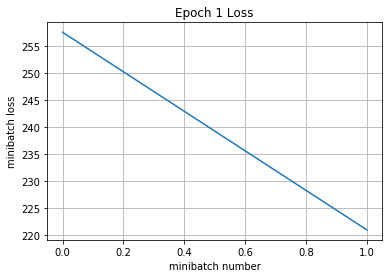

Model saved in file : checkpoint/concat_1024_mix_18_elu
Epoch 2, Overall loss = 0.0403, accuracy of 0.984 and f1 score of 0.98
Epoch 3, Overall loss = 0.0416, accuracy of 0.984 and f1 score of 0.98
Epoch 4, Overall loss = 0.043, accuracy of 0.985 and f1 score of 0.98
Epoch 5, Overall loss = 0.0401, accuracy of 0.986 and f1 score of 0.98
Epoch 6, Overall loss = 0.0422, accuracy of 0.984 and f1 score of 0.98
Epoch 7, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 8, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Epoch 9, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.99
Epoch 10, Overall loss = 0.0416, accuracy of 0.984 and f1 score of 0.98
Epoch 11, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.31, accuracy of 0.93 and f1 score of 0.932


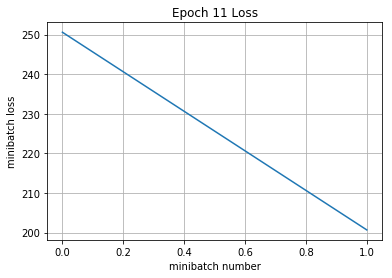

Model saved in file : checkpoint/concat_1024_mix_18_elu
Epoch 12, Overall loss = 0.0411, accuracy of 0.986 and f1 score of 0.98
Epoch 13, Overall loss = 0.0416, accuracy of 0.985 and f1 score of 0.98
Epoch 14, Overall loss = 0.0413, accuracy of 0.986 and f1 score of 0.98
Epoch 15, Overall loss = 0.043, accuracy of 0.983 and f1 score of 0.98
Epoch 16, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 17, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 18, Overall loss = 0.0385, accuracy of 0.985 and f1 score of 0.98
Epoch 19, Overall loss = 0.0409, accuracy of 0.985 and f1 score of 0.98
Epoch 20, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 21, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.3, accuracy of 0.93 and f1 score of 0.931


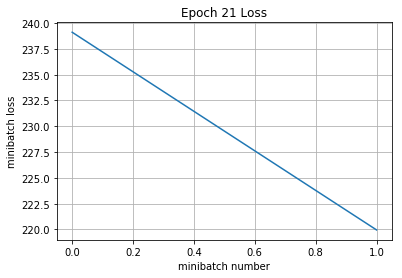

Model saved in file : checkpoint/concat_1024_mix_18_elu
Epoch 22, Overall loss = 0.039, accuracy of 0.987 and f1 score of 0.98
Epoch 23, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 24, Overall loss = 0.0429, accuracy of 0.985 and f1 score of 0.98
Epoch 25, Overall loss = 0.0424, accuracy of 0.984 and f1 score of 0.98
Epoch 26, Overall loss = 0.0421, accuracy of 0.986 and f1 score of 0.98
Epoch 27, Overall loss = 0.0428, accuracy of 0.984 and f1 score of 0.98
Epoch 28, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 29, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.99
Epoch 30, Overall loss = 0.0388, accuracy of 0.987 and f1 score of 0.99
Epoch 31, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.311, accuracy of 0.931 and f1 score of 0.934


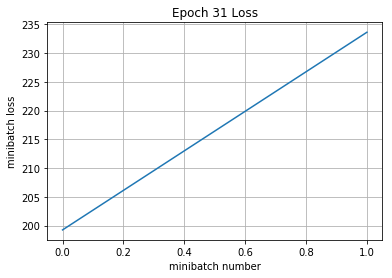

Epoch 32, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.98
Epoch 33, Overall loss = 0.0403, accuracy of 0.985 and f1 score of 0.98
Epoch 34, Overall loss = 0.0416, accuracy of 0.986 and f1 score of 0.98
Epoch 35, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 36, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 37, Overall loss = 0.0405, accuracy of 0.987 and f1 score of 0.99
Epoch 38, Overall loss = 0.0409, accuracy of 0.985 and f1 score of 0.98
Epoch 39, Overall loss = 0.0416, accuracy of 0.985 and f1 score of 0.98
Epoch 40, Overall loss = 0.0403, accuracy of 0.985 and f1 score of 0.98
Epoch 41, Overall loss = 0.0394, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.326, accuracy of 0.928 and f1 score of 0.93


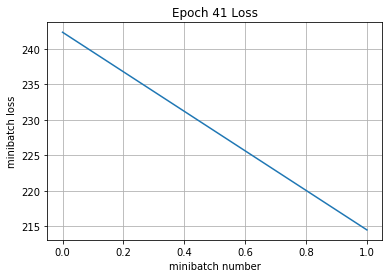

Epoch 42, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 43, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.99
Epoch 44, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 45, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 46, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.98
Epoch 47, Overall loss = 0.0419, accuracy of 0.986 and f1 score of 0.99
Epoch 48, Overall loss = 0.0395, accuracy of 0.985 and f1 score of 0.98
Epoch 49, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.99
Epoch 50, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Iteration 100: with minibatch training loss = 0.0407, accuracy of 0.98, and f1 score of 0.98
Epoch 51, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.307, accuracy of 0.929 and f1 score of 0.93


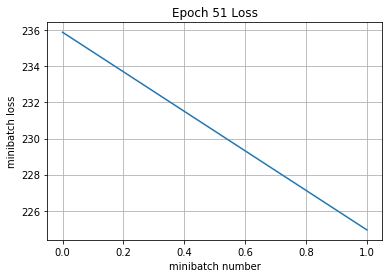

Epoch 52, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.99
Epoch 53, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 54, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.99
Epoch 55, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 56, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 57, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Epoch 58, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 59, Overall loss = 0.0392, accuracy of 0.985 and f1 score of 0.98
Epoch 60, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.99
Epoch 61, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.929 and f1 score of 0.931


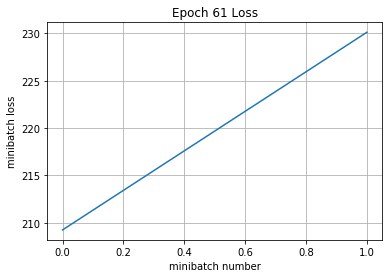

Epoch 62, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 63, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 64, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 65, Overall loss = 0.0411, accuracy of 0.985 and f1 score of 0.98
Epoch 66, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 67, Overall loss = 0.0409, accuracy of 0.985 and f1 score of 0.98
Epoch 68, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 69, Overall loss = 0.0417, accuracy of 0.985 and f1 score of 0.98
Epoch 70, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 71, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.322, accuracy of 0.931 and f1 score of 0.935


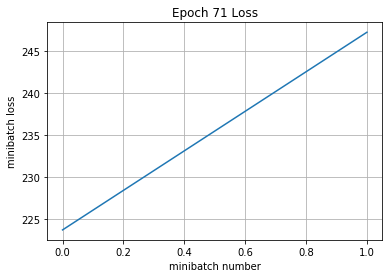

Epoch 72, Overall loss = 0.042, accuracy of 0.985 and f1 score of 0.98
Epoch 73, Overall loss = 0.0399, accuracy of 0.987 and f1 score of 0.99
Epoch 74, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.99
Epoch 75, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 76, Overall loss = 0.0417, accuracy of 0.985 and f1 score of 0.98
Epoch 77, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.99
Epoch 78, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 79, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Epoch 80, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 81, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.309, accuracy of 0.93 and f1 score of 0.932


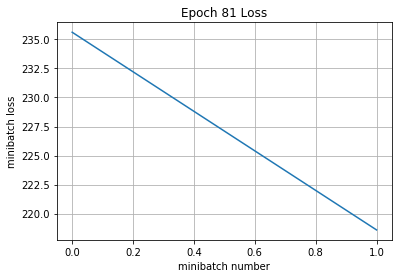

Epoch 82, Overall loss = 0.043, accuracy of 0.984 and f1 score of 0.98
Epoch 83, Overall loss = 0.0369, accuracy of 0.988 and f1 score of 0.99
Epoch 84, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.99
Epoch 85, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 86, Overall loss = 0.0386, accuracy of 0.985 and f1 score of 0.98
Epoch 87, Overall loss = 0.0397, accuracy of 0.987 and f1 score of 0.98
Epoch 88, Overall loss = 0.0416, accuracy of 0.985 and f1 score of 0.98
Epoch 89, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 90, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 91, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.312, accuracy of 0.927 and f1 score of 0.929


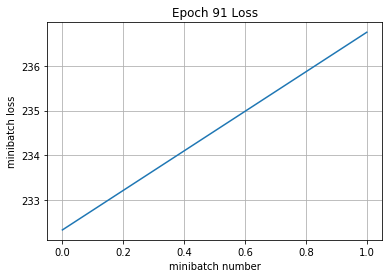

Epoch 92, Overall loss = 0.0362, accuracy of 0.986 and f1 score of 0.98
Epoch 93, Overall loss = 0.039, accuracy of 0.985 and f1 score of 0.98
Epoch 94, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 95, Overall loss = 0.0412, accuracy of 0.985 and f1 score of 0.98
Epoch 96, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 97, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.99
Epoch 98, Overall loss = 0.0397, accuracy of 0.987 and f1 score of 0.99
Epoch 99, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 100, Overall loss = 0.0414, accuracy of 0.986 and f1 score of 0.98
Iteration 200: with minibatch training loss = 0.0436, accuracy of 0.98, and f1 score of 0.98
Epoch 101, Overall loss = 0.0414, accuracy of 0.984 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.933 and f1 score of 0.933


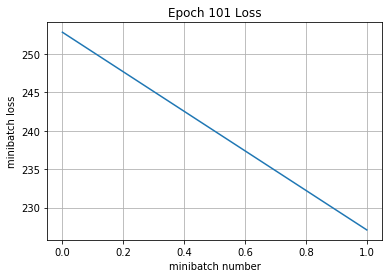

Epoch 102, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 103, Overall loss = 0.0419, accuracy of 0.985 and f1 score of 0.98
Epoch 104, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.99
Epoch 105, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 106, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 107, Overall loss = 0.0362, accuracy of 0.988 and f1 score of 0.99
Epoch 108, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.99
Epoch 109, Overall loss = 0.0409, accuracy of 0.987 and f1 score of 0.98
Epoch 110, Overall loss = 0.0395, accuracy of 0.987 and f1 score of 0.99
Epoch 111, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.932 and f1 score of 0.935


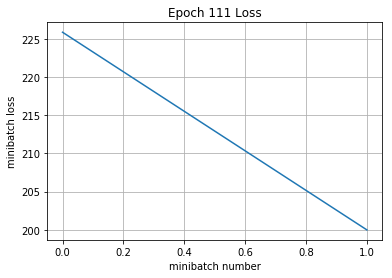

Epoch 112, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 113, Overall loss = 0.0399, accuracy of 0.985 and f1 score of 0.98
Epoch 114, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 115, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 116, Overall loss = 0.0388, accuracy of 0.985 and f1 score of 0.98
Epoch 117, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.99
Epoch 118, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 119, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Epoch 120, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.99
Epoch 121, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.327, accuracy of 0.928 and f1 score of 0.93


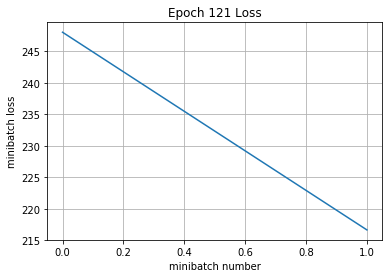

Epoch 122, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 123, Overall loss = 0.0415, accuracy of 0.984 and f1 score of 0.98
Epoch 124, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 125, Overall loss = 0.0419, accuracy of 0.984 and f1 score of 0.98
Epoch 126, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.99
Epoch 127, Overall loss = 0.0402, accuracy of 0.987 and f1 score of 0.98
Epoch 128, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 129, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 130, Overall loss = 0.038, accuracy of 0.985 and f1 score of 0.98
Epoch 131, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.932 and f1 score of 0.933


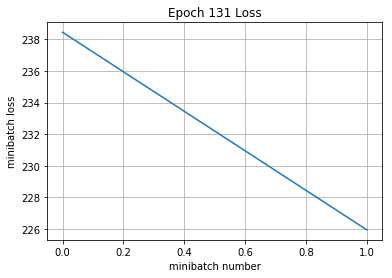

Epoch 132, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 133, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Epoch 134, Overall loss = 0.0419, accuracy of 0.985 and f1 score of 0.98
Epoch 135, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 136, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 137, Overall loss = 0.0416, accuracy of 0.984 and f1 score of 0.98
Epoch 138, Overall loss = 0.0448, accuracy of 0.984 and f1 score of 0.98
Epoch 139, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 140, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 141, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.305, accuracy of 0.933 and f1 score of 0.937


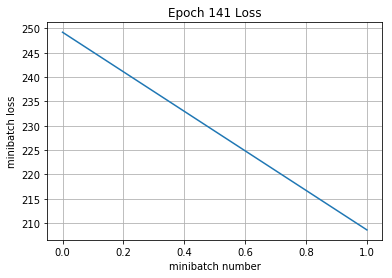

Epoch 142, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.99
Epoch 143, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.99
Epoch 144, Overall loss = 0.0426, accuracy of 0.984 and f1 score of 0.98
Epoch 145, Overall loss = 0.041, accuracy of 0.986 and f1 score of 0.98
Epoch 146, Overall loss = 0.042, accuracy of 0.985 and f1 score of 0.98
Epoch 147, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Epoch 148, Overall loss = 0.0394, accuracy of 0.985 and f1 score of 0.98
Epoch 149, Overall loss = 0.0402, accuracy of 0.984 and f1 score of 0.98
Epoch 150, Overall loss = 0.0373, accuracy of 0.988 and f1 score of 0.99
Iteration 300: with minibatch training loss = 0.038, accuracy of 0.99, and f1 score of 0.99
Epoch 151, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.305, accuracy of 0.932 and f1 score of 0.935


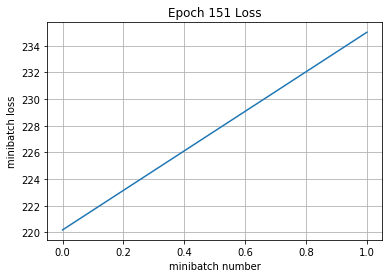

Epoch 152, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 153, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 154, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 155, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Epoch 156, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 157, Overall loss = 0.0423, accuracy of 0.985 and f1 score of 0.98
Epoch 158, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 159, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Epoch 160, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 161, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.303, accuracy of 0.931 and f1 score of 0.933


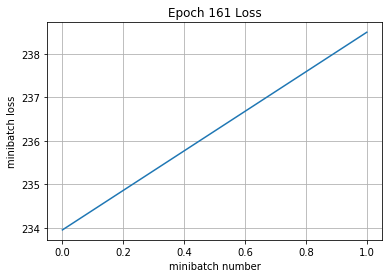

Epoch 162, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.99
Epoch 163, Overall loss = 0.0409, accuracy of 0.985 and f1 score of 0.99
Epoch 164, Overall loss = 0.0421, accuracy of 0.985 and f1 score of 0.98
Epoch 165, Overall loss = 0.043, accuracy of 0.985 and f1 score of 0.98
Epoch 166, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 167, Overall loss = 0.0409, accuracy of 0.986 and f1 score of 0.98
Epoch 168, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 169, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 170, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 171, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.308, accuracy of 0.927 and f1 score of 0.929


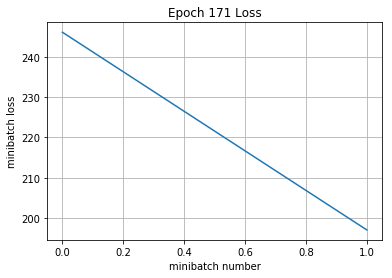

Epoch 172, Overall loss = 0.0413, accuracy of 0.986 and f1 score of 0.98
Epoch 173, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 174, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 175, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Epoch 176, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 177, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 178, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 179, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 180, Overall loss = 0.0393, accuracy of 0.987 and f1 score of 0.98
Epoch 181, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.307, accuracy of 0.931 and f1 score of 0.93


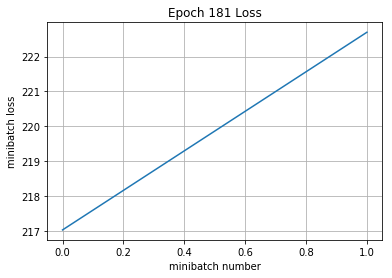

Epoch 182, Overall loss = 0.0387, accuracy of 0.985 and f1 score of 0.98
Epoch 183, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 184, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 185, Overall loss = 0.0384, accuracy of 0.985 and f1 score of 0.98
Epoch 186, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.98
Epoch 187, Overall loss = 0.0413, accuracy of 0.986 and f1 score of 0.99
Epoch 188, Overall loss = 0.0413, accuracy of 0.984 and f1 score of 0.98
Epoch 189, Overall loss = 0.042, accuracy of 0.985 and f1 score of 0.98
Epoch 190, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 191, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.309, accuracy of 0.932 and f1 score of 0.933


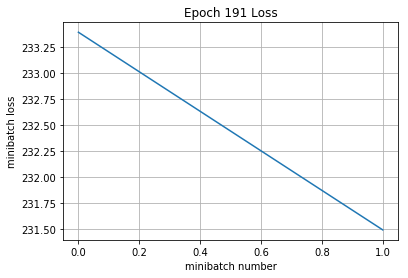

Epoch 192, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 193, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.99
Epoch 194, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.99
Epoch 195, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 196, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 197, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 198, Overall loss = 0.0427, accuracy of 0.985 and f1 score of 0.98
Epoch 199, Overall loss = 0.0378, accuracy of 0.988 and f1 score of 0.99
Epoch 200, Overall loss = 0.0401, accuracy of 0.986 and f1 score of 0.98
Iteration 400: with minibatch training loss = 0.037, accuracy of 0.99, and f1 score of 0.99
Epoch 201, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.929 and f1 score of 0.932


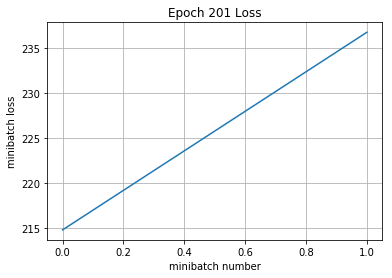

Epoch 202, Overall loss = 0.0381, accuracy of 0.985 and f1 score of 0.98
Epoch 203, Overall loss = 0.0372, accuracy of 0.988 and f1 score of 0.99
Epoch 204, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 205, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 206, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 207, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 208, Overall loss = 0.0421, accuracy of 0.984 and f1 score of 0.98
Epoch 209, Overall loss = 0.0413, accuracy of 0.984 and f1 score of 0.98
Epoch 210, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.98
Epoch 211, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.928 and f1 score of 0.93


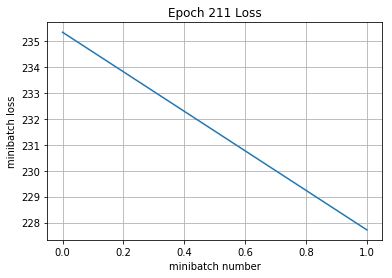

Epoch 212, Overall loss = 0.0413, accuracy of 0.985 and f1 score of 0.98
Epoch 213, Overall loss = 0.042, accuracy of 0.985 and f1 score of 0.98
Epoch 214, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 215, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 216, Overall loss = 0.0417, accuracy of 0.985 and f1 score of 0.98
Epoch 217, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 218, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 219, Overall loss = 0.0424, accuracy of 0.985 and f1 score of 0.98
Epoch 220, Overall loss = 0.0403, accuracy of 0.987 and f1 score of 0.98
Epoch 221, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.309, accuracy of 0.93 and f1 score of 0.932


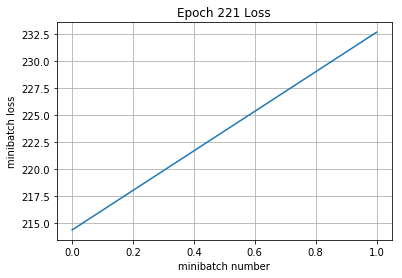

Epoch 222, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 223, Overall loss = 0.0411, accuracy of 0.985 and f1 score of 0.98
Epoch 224, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 225, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 226, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 227, Overall loss = 0.0392, accuracy of 0.985 and f1 score of 0.98
Epoch 228, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 229, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 230, Overall loss = 0.0407, accuracy of 0.985 and f1 score of 0.98
Epoch 231, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.931 and f1 score of 0.931


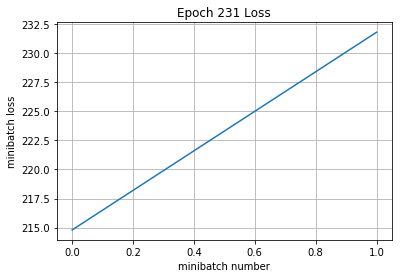

Epoch 232, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 233, Overall loss = 0.0416, accuracy of 0.985 and f1 score of 0.98
Epoch 234, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 235, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Epoch 236, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 237, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 238, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 239, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 240, Overall loss = 0.0421, accuracy of 0.985 and f1 score of 0.98
Epoch 241, Overall loss = 0.0409, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.309, accuracy of 0.933 and f1 score of 0.934


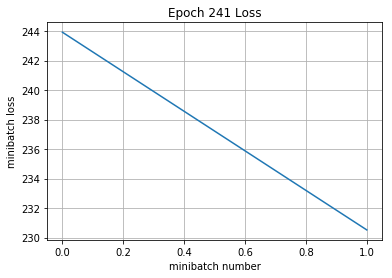

Epoch 242, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.98
Epoch 243, Overall loss = 0.0401, accuracy of 0.986 and f1 score of 0.99
Epoch 244, Overall loss = 0.0376, accuracy of 0.985 and f1 score of 0.98
Epoch 245, Overall loss = 0.0392, accuracy of 0.987 and f1 score of 0.99
Epoch 246, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 247, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 248, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 249, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 250, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Iteration 500: with minibatch training loss = 0.0373, accuracy of 0.99, and f1 score of 0.98
Epoch 251, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.929 and f1 score of 0.93


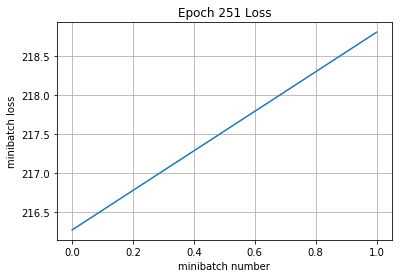

Epoch 252, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Epoch 253, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 254, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 255, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 256, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 257, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 258, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 259, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 260, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 261, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.301, accuracy of 0.936 and f1 score of 0.938


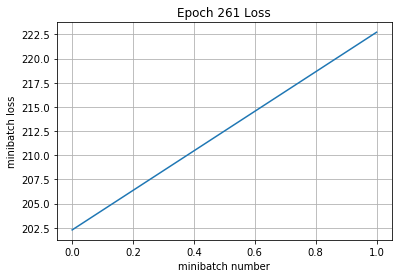

Epoch 262, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 263, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 264, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 265, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 266, Overall loss = 0.0427, accuracy of 0.985 and f1 score of 0.98
Epoch 267, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 268, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.99
Epoch 269, Overall loss = 0.0425, accuracy of 0.984 and f1 score of 0.98
Epoch 270, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.99
Epoch 271, Overall loss = 0.0412, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.929 and f1 score of 0.934


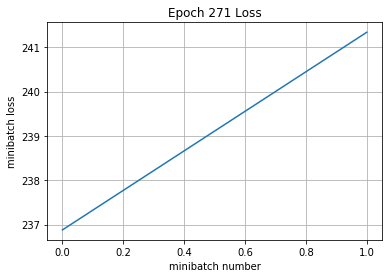

Epoch 272, Overall loss = 0.0416, accuracy of 0.986 and f1 score of 0.98
Epoch 273, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 274, Overall loss = 0.042, accuracy of 0.983 and f1 score of 0.98
Epoch 275, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 276, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.99
Epoch 277, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 278, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 279, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 280, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.99
Epoch 281, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.928 and f1 score of 0.93


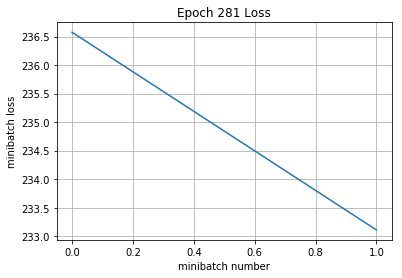

Epoch 282, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Epoch 283, Overall loss = 0.0417, accuracy of 0.985 and f1 score of 0.98
Epoch 284, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 285, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.99
Epoch 286, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.99
Epoch 287, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 288, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.99
Epoch 289, Overall loss = 0.0368, accuracy of 0.988 and f1 score of 0.98
Epoch 290, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 291, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.309, accuracy of 0.929 and f1 score of 0.929


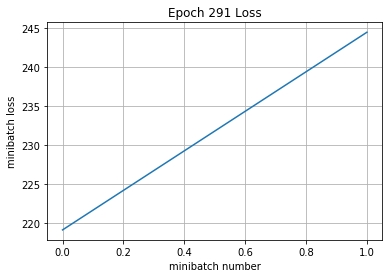

Epoch 292, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Epoch 293, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Epoch 294, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 295, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 296, Overall loss = 0.0396, accuracy of 0.987 and f1 score of 0.98
Epoch 297, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 298, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 299, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 300, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Iteration 600: with minibatch training loss = 0.0378, accuracy of 0.99, and f1 score of 0.99
Epoch 301, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.327, accuracy of 0.926 and f1 score of 0.929


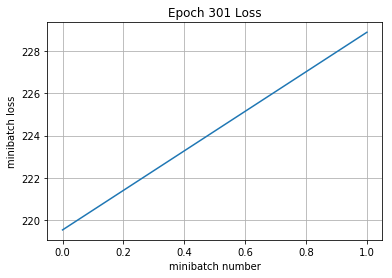

Epoch 302, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 303, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.99
Epoch 304, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.99
Epoch 305, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 306, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.98
Epoch 307, Overall loss = 0.0411, accuracy of 0.986 and f1 score of 0.98
Epoch 308, Overall loss = 0.0381, accuracy of 0.985 and f1 score of 0.98
Epoch 309, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.99
Epoch 310, Overall loss = 0.039, accuracy of 0.987 and f1 score of 0.98
Epoch 311, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.315, accuracy of 0.933 and f1 score of 0.935


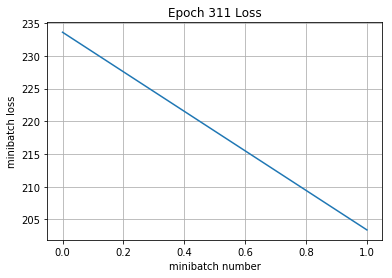

Epoch 312, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 313, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 314, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 315, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.98
Epoch 316, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Epoch 317, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 318, Overall loss = 0.041, accuracy of 0.986 and f1 score of 0.99
Epoch 319, Overall loss = 0.0411, accuracy of 0.985 and f1 score of 0.98
Epoch 320, Overall loss = 0.0399, accuracy of 0.987 and f1 score of 0.98
Epoch 321, Overall loss = 0.0417, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.316, accuracy of 0.93 and f1 score of 0.932


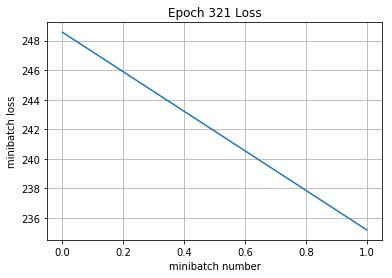

Epoch 322, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 323, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 324, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.99
Epoch 325, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Epoch 326, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 327, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 328, Overall loss = 0.042, accuracy of 0.985 and f1 score of 0.98
Epoch 329, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Epoch 330, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.99
Epoch 331, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.323, accuracy of 0.929 and f1 score of 0.931


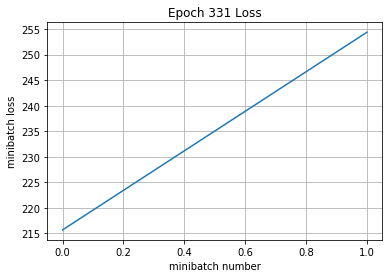

Epoch 332, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 333, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.98
Epoch 334, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 335, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 336, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 337, Overall loss = 0.0409, accuracy of 0.986 and f1 score of 0.98
Epoch 338, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 339, Overall loss = 0.0404, accuracy of 0.984 and f1 score of 0.98
Epoch 340, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 341, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.32, accuracy of 0.93 and f1 score of 0.931


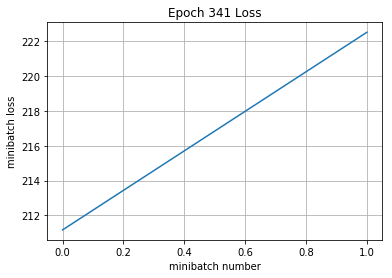

Epoch 342, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 343, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Epoch 344, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 345, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 346, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 347, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 348, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 349, Overall loss = 0.0407, accuracy of 0.985 and f1 score of 0.98
Epoch 350, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Iteration 700: with minibatch training loss = 0.0381, accuracy of 0.99, and f1 score of 0.98
Epoch 351, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.289, accuracy of 0.933 and f1 score of 0.936


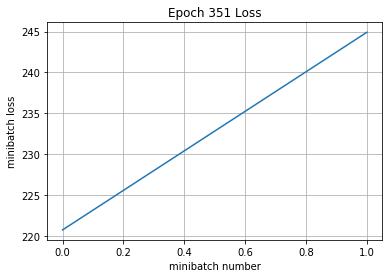

Model saved in file : checkpoint/concat_1024_mix_18_elu
Epoch 352, Overall loss = 0.0365, accuracy of 0.985 and f1 score of 0.98
Epoch 353, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.99
Epoch 354, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.99
Epoch 355, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 356, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 357, Overall loss = 0.0399, accuracy of 0.985 and f1 score of 0.98
Epoch 358, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 359, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Epoch 360, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 361, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.314, accuracy of 0.927 and f1 score of 0.929


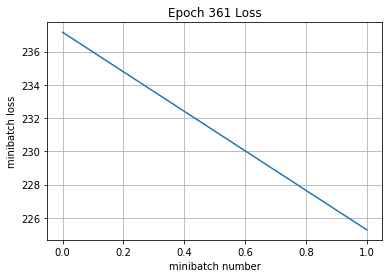

Epoch 362, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 363, Overall loss = 0.0414, accuracy of 0.985 and f1 score of 0.98
Epoch 364, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 365, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 366, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 367, Overall loss = 0.0389, accuracy of 0.985 and f1 score of 0.98
Epoch 368, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.99
Epoch 369, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 370, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 371, Overall loss = 0.0411, accuracy of 0.984 and f1 score of 0.98
Validation loss, Overall loss = 0.318, accuracy of 0.93 and f1 score of 0.93


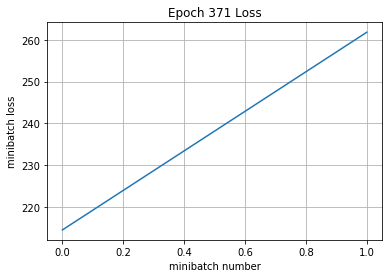

Epoch 372, Overall loss = 0.0403, accuracy of 0.985 and f1 score of 0.98
Epoch 373, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 374, Overall loss = 0.0419, accuracy of 0.984 and f1 score of 0.98
Epoch 375, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 376, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 377, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 378, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 379, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 380, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 381, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.304, accuracy of 0.933 and f1 score of 0.935


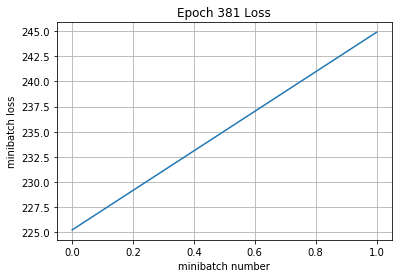

Epoch 382, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 383, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 384, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 385, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 386, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 387, Overall loss = 0.0428, accuracy of 0.984 and f1 score of 0.98
Epoch 388, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 389, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 390, Overall loss = 0.0425, accuracy of 0.984 and f1 score of 0.98
Epoch 391, Overall loss = 0.0412, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.932 and f1 score of 0.932


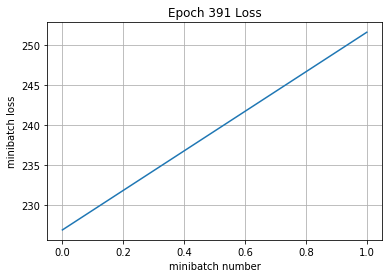

Epoch 392, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.98
Epoch 393, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.99
Epoch 394, Overall loss = 0.0388, accuracy of 0.987 and f1 score of 0.98
Epoch 395, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 396, Overall loss = 0.0433, accuracy of 0.985 and f1 score of 0.98
Epoch 397, Overall loss = 0.0418, accuracy of 0.985 and f1 score of 0.98
Epoch 398, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 399, Overall loss = 0.0426, accuracy of 0.985 and f1 score of 0.98
Epoch 400, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Iteration 800: with minibatch training loss = 0.0412, accuracy of 0.98, and f1 score of 0.99
Epoch 401, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.931 and f1 score of 0.931


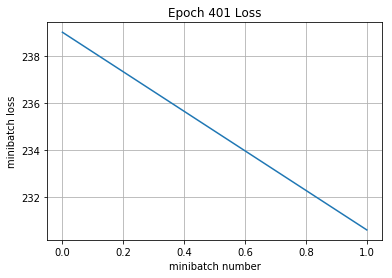

Epoch 402, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Epoch 403, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 404, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 405, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 406, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.99
Epoch 407, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 408, Overall loss = 0.0423, accuracy of 0.986 and f1 score of 0.98
Epoch 409, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.99
Epoch 410, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 411, Overall loss = 0.0401, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.309, accuracy of 0.932 and f1 score of 0.933


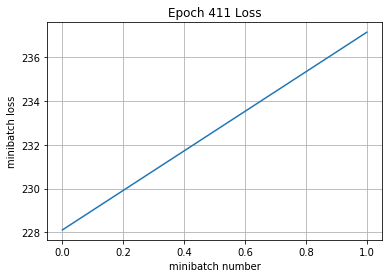

Epoch 412, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 413, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.99
Epoch 414, Overall loss = 0.0422, accuracy of 0.985 and f1 score of 0.98
Epoch 415, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 416, Overall loss = 0.0417, accuracy of 0.985 and f1 score of 0.98
Epoch 417, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 418, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.98
Epoch 419, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 420, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 421, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.322, accuracy of 0.929 and f1 score of 0.932


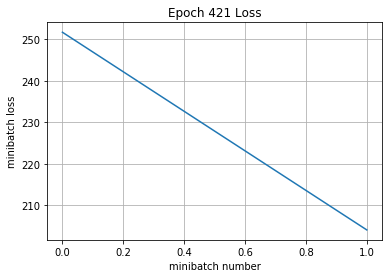

Epoch 422, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 423, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 424, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.99
Epoch 425, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.99
Epoch 426, Overall loss = 0.041, accuracy of 0.985 and f1 score of 0.98
Epoch 427, Overall loss = 0.0395, accuracy of 0.985 and f1 score of 0.98
Epoch 428, Overall loss = 0.0411, accuracy of 0.985 and f1 score of 0.98
Epoch 429, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 430, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 431, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.932 and f1 score of 0.935


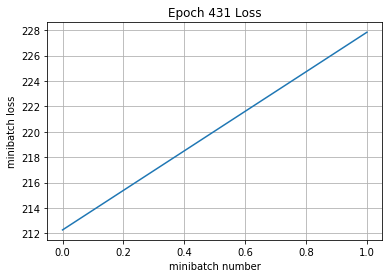

Epoch 432, Overall loss = 0.0418, accuracy of 0.985 and f1 score of 0.98
Epoch 433, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Epoch 434, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 435, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 436, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 437, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 438, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Epoch 439, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 440, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 441, Overall loss = 0.0381, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.315, accuracy of 0.932 and f1 score of 0.934


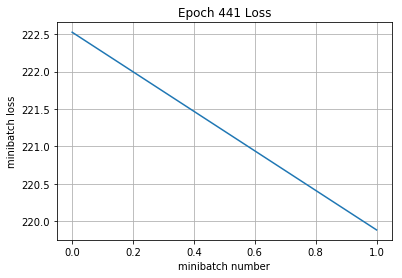

Epoch 442, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 443, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 444, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.99
Epoch 445, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.99
Epoch 446, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.99
Epoch 447, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 448, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 449, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.98
Epoch 450, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Iteration 900: with minibatch training loss = 0.037, accuracy of 0.99, and f1 score of 0.98
Epoch 451, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.93 and f1 score of 0.936


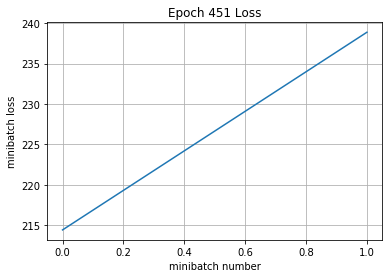

Epoch 452, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.99
Epoch 453, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.99
Epoch 454, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Epoch 455, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 456, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 457, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.99
Epoch 458, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 459, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 460, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 461, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.928 and f1 score of 0.93


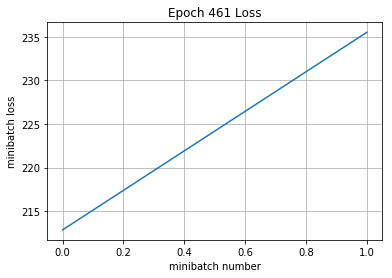

Epoch 462, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 463, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.99
Epoch 464, Overall loss = 0.0389, accuracy of 0.985 and f1 score of 0.98
Epoch 465, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Epoch 466, Overall loss = 0.0412, accuracy of 0.984 and f1 score of 0.98
Epoch 467, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Epoch 468, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.99
Epoch 469, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 470, Overall loss = 0.039, accuracy of 0.985 and f1 score of 0.98
Epoch 471, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.321, accuracy of 0.931 and f1 score of 0.933


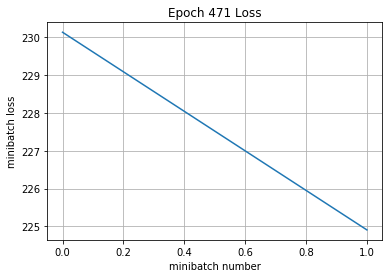

Epoch 472, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 473, Overall loss = 0.0406, accuracy of 0.987 and f1 score of 0.99
Epoch 474, Overall loss = 0.0412, accuracy of 0.985 and f1 score of 0.98
Epoch 475, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Epoch 476, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.99
Epoch 477, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 478, Overall loss = 0.0392, accuracy of 0.985 and f1 score of 0.98
Epoch 479, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 480, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 481, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.926 and f1 score of 0.929


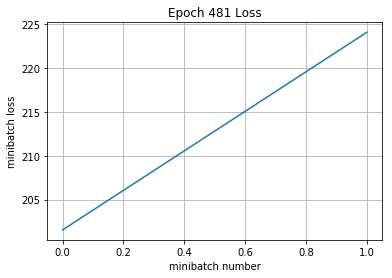

Epoch 482, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 483, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 484, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 485, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 486, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 487, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 488, Overall loss = 0.0358, accuracy of 0.988 and f1 score of 0.99
Epoch 489, Overall loss = 0.0384, accuracy of 0.985 and f1 score of 0.98
Epoch 490, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.98
Epoch 491, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.308, accuracy of 0.932 and f1 score of 0.933


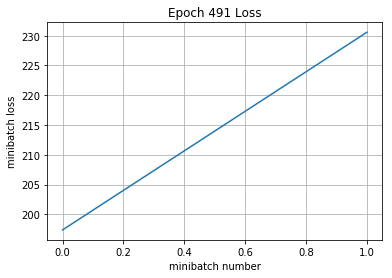

Epoch 492, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 493, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 494, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 495, Overall loss = 0.041, accuracy of 0.985 and f1 score of 0.98
Epoch 496, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 497, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 498, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 499, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 500, Overall loss = 0.0397, accuracy of 0.987 and f1 score of 0.99
Iteration 1000: with minibatch training loss = 0.04, accuracy of 0.99, and f1 score of 0.99
Epoch 501, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.312, accuracy of 0.93 and f1 score of 0.931


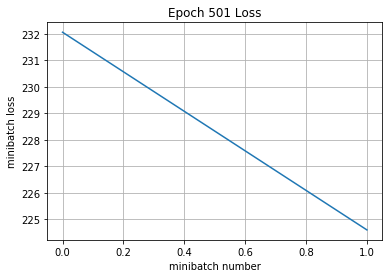

Epoch 502, Overall loss = 0.0384, accuracy of 0.985 and f1 score of 0.98
Epoch 503, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 504, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 505, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 506, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.99
Epoch 507, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 508, Overall loss = 0.038, accuracy of 0.985 and f1 score of 0.98
Epoch 509, Overall loss = 0.0385, accuracy of 0.985 and f1 score of 0.98
Epoch 510, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 511, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.927 and f1 score of 0.928


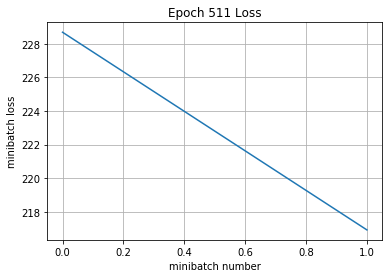

Epoch 512, Overall loss = 0.039, accuracy of 0.985 and f1 score of 0.98
Epoch 513, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 514, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 515, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 516, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 517, Overall loss = 0.0412, accuracy of 0.985 and f1 score of 0.98
Epoch 518, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 519, Overall loss = 0.0409, accuracy of 0.985 and f1 score of 0.98
Epoch 520, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 521, Overall loss = 0.0392, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.312, accuracy of 0.93 and f1 score of 0.931


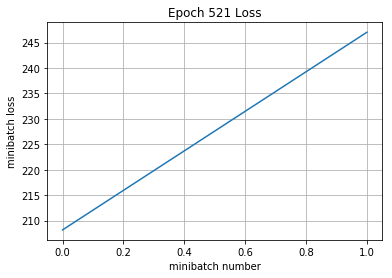

Epoch 522, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 523, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 524, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 525, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 526, Overall loss = 0.0388, accuracy of 0.987 and f1 score of 0.99
Epoch 527, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 528, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 529, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 530, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.99
Epoch 531, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.305, accuracy of 0.933 and f1 score of 0.936


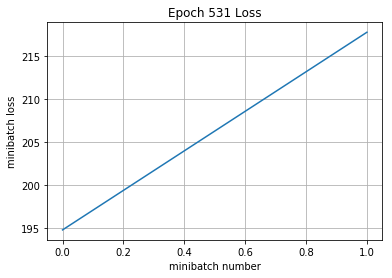

Epoch 532, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 533, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 534, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Epoch 535, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 536, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 537, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 538, Overall loss = 0.039, accuracy of 0.987 and f1 score of 0.99
Epoch 539, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 540, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 541, Overall loss = 0.0414, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.926 and f1 score of 0.929


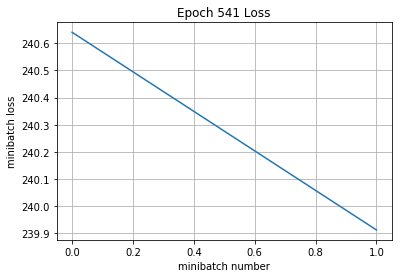

Epoch 542, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 543, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.99
Epoch 544, Overall loss = 0.0418, accuracy of 0.985 and f1 score of 0.98
Epoch 545, Overall loss = 0.0379, accuracy of 0.985 and f1 score of 0.98
Epoch 546, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 547, Overall loss = 0.0406, accuracy of 0.984 and f1 score of 0.98
Epoch 548, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 549, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.99
Epoch 550, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.98
Iteration 1100: with minibatch training loss = 0.0343, accuracy of 0.99, and f1 score of 0.99
Epoch 551, Overall loss = 0.038, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.328, accuracy of 0.929 and f1 score of 0.931


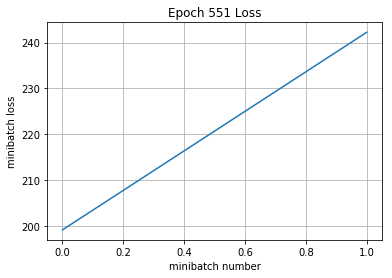

Epoch 552, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 553, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 554, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.99
Epoch 555, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 556, Overall loss = 0.0363, accuracy of 0.985 and f1 score of 0.98
Epoch 557, Overall loss = 0.0411, accuracy of 0.985 and f1 score of 0.98
Epoch 558, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 559, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.99
Epoch 560, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 561, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.326, accuracy of 0.929 and f1 score of 0.93


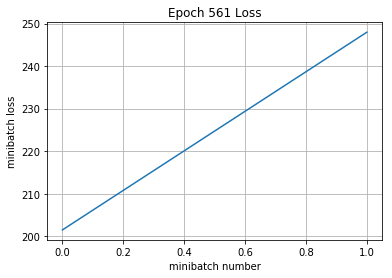

Epoch 562, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 563, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 564, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 565, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 566, Overall loss = 0.0416, accuracy of 0.986 and f1 score of 0.98
Epoch 567, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 568, Overall loss = 0.04, accuracy of 0.987 and f1 score of 0.98
Epoch 569, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 570, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 571, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.314, accuracy of 0.93 and f1 score of 0.933


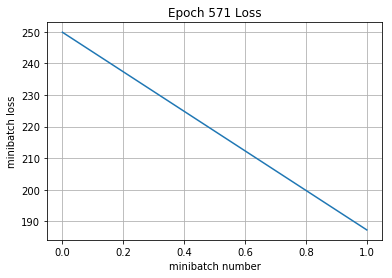

Epoch 572, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 573, Overall loss = 0.0374, accuracy of 0.988 and f1 score of 0.99
Epoch 574, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 575, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 576, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 577, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 578, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 579, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Epoch 580, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 581, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.319, accuracy of 0.931 and f1 score of 0.931


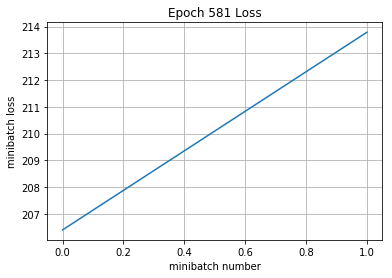

Epoch 582, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 583, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 584, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 585, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 586, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 587, Overall loss = 0.0419, accuracy of 0.985 and f1 score of 0.98
Epoch 588, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 589, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.98
Epoch 590, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 591, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.306, accuracy of 0.932 and f1 score of 0.933


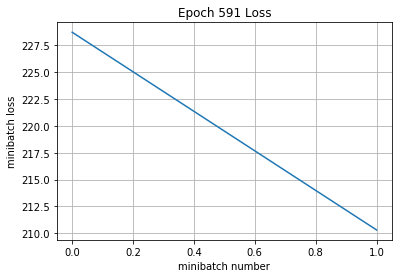

Epoch 592, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 593, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Epoch 594, Overall loss = 0.0423, accuracy of 0.985 and f1 score of 0.98
Epoch 595, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 596, Overall loss = 0.0351, accuracy of 0.986 and f1 score of 0.99
Epoch 597, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 598, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 599, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 600, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Iteration 1200: with minibatch training loss = 0.0383, accuracy of 0.99, and f1 score of 0.98
Epoch 601, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.31, accuracy of 0.932 and f1 score of 0.937


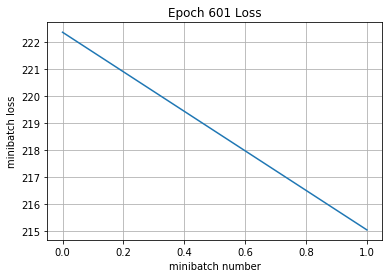

Epoch 602, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Epoch 603, Overall loss = 0.039, accuracy of 0.985 and f1 score of 0.98
Epoch 604, Overall loss = 0.0358, accuracy of 0.988 and f1 score of 0.99
Epoch 605, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 606, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.99
Epoch 607, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 608, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.99
Epoch 609, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 610, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 611, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.331, accuracy of 0.927 and f1 score of 0.927


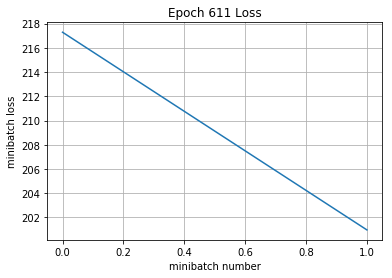

Epoch 612, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 613, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.99
Epoch 614, Overall loss = 0.0381, accuracy of 0.985 and f1 score of 0.99
Epoch 615, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Epoch 616, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.98
Epoch 617, Overall loss = 0.0403, accuracy of 0.986 and f1 score of 0.98
Epoch 618, Overall loss = 0.0399, accuracy of 0.985 and f1 score of 0.98
Epoch 619, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 620, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 621, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.307, accuracy of 0.931 and f1 score of 0.932


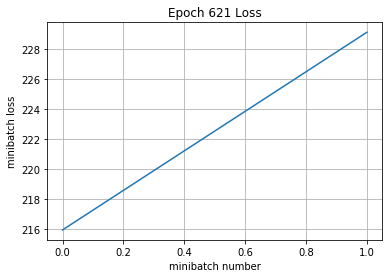

Epoch 622, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.98
Epoch 623, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.99
Epoch 624, Overall loss = 0.0394, accuracy of 0.985 and f1 score of 0.98
Epoch 625, Overall loss = 0.0381, accuracy of 0.985 and f1 score of 0.98
Epoch 626, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 627, Overall loss = 0.0365, accuracy of 0.986 and f1 score of 0.99
Epoch 628, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.99
Epoch 629, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 630, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 631, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.311, accuracy of 0.934 and f1 score of 0.939


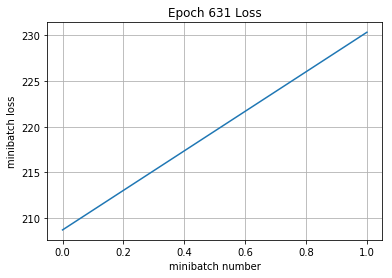

Epoch 632, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 633, Overall loss = 0.0413, accuracy of 0.985 and f1 score of 0.98
Epoch 634, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 635, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 636, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 637, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 638, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 639, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 640, Overall loss = 0.0371, accuracy of 0.988 and f1 score of 0.99
Epoch 641, Overall loss = 0.0407, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.93 and f1 score of 0.932


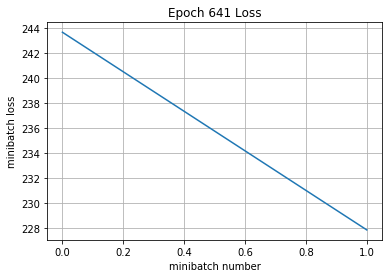

Epoch 642, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 643, Overall loss = 0.0417, accuracy of 0.984 and f1 score of 0.98
Epoch 644, Overall loss = 0.0395, accuracy of 0.985 and f1 score of 0.98
Epoch 645, Overall loss = 0.0382, accuracy of 0.985 and f1 score of 0.98
Epoch 646, Overall loss = 0.0398, accuracy of 0.987 and f1 score of 0.98
Epoch 647, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 648, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 649, Overall loss = 0.0395, accuracy of 0.985 and f1 score of 0.98
Epoch 650, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Iteration 1300: with minibatch training loss = 0.0343, accuracy of 0.99, and f1 score of 0.99
Epoch 651, Overall loss = 0.0392, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.93 and f1 score of 0.934


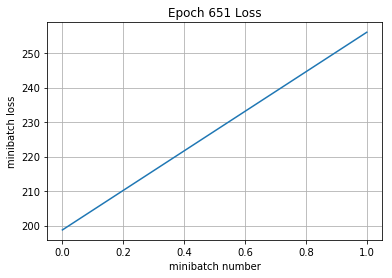

Epoch 652, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 653, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.99
Epoch 654, Overall loss = 0.0398, accuracy of 0.987 and f1 score of 0.99
Epoch 655, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 656, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 657, Overall loss = 0.0374, accuracy of 0.985 and f1 score of 0.98
Epoch 658, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 659, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.99
Epoch 660, Overall loss = 0.0367, accuracy of 0.985 and f1 score of 0.98
Epoch 661, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.312, accuracy of 0.929 and f1 score of 0.932


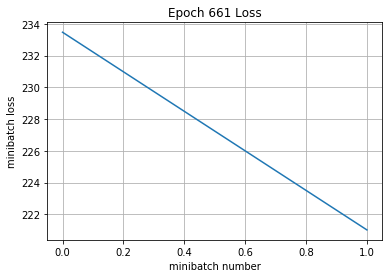

Epoch 662, Overall loss = 0.0394, accuracy of 0.985 and f1 score of 0.98
Epoch 663, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 664, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.98
Epoch 665, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 666, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 667, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.99
Epoch 668, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 669, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 670, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Epoch 671, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.319, accuracy of 0.925 and f1 score of 0.928


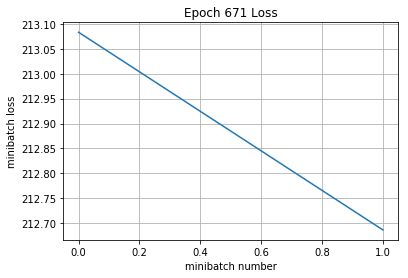

Epoch 672, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 673, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 674, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 675, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 676, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Epoch 677, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 678, Overall loss = 0.0374, accuracy of 0.985 and f1 score of 0.98
Epoch 679, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 680, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Epoch 681, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.929 and f1 score of 0.931


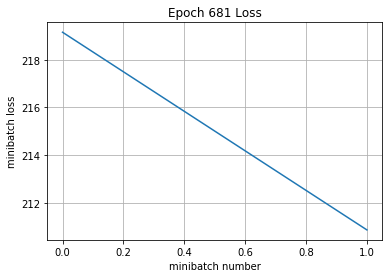

Epoch 682, Overall loss = 0.0401, accuracy of 0.987 and f1 score of 0.99
Epoch 683, Overall loss = 0.0384, accuracy of 0.985 and f1 score of 0.98
Epoch 684, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 685, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 686, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 687, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 688, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 689, Overall loss = 0.0426, accuracy of 0.986 and f1 score of 0.99
Epoch 690, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.99
Epoch 691, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.318, accuracy of 0.928 and f1 score of 0.931


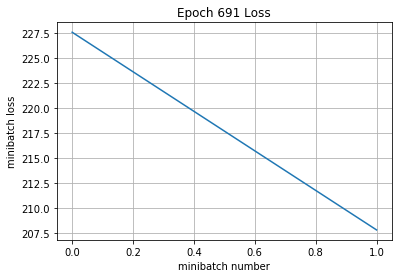

Epoch 692, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 693, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 694, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 695, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Epoch 696, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.99
Epoch 697, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 698, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 699, Overall loss = 0.0401, accuracy of 0.986 and f1 score of 0.98
Epoch 700, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Iteration 1400: with minibatch training loss = 0.0335, accuracy of 0.99, and f1 score of 0.99
Epoch 701, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.306, accuracy of 0.93 and f1 score of 0.931


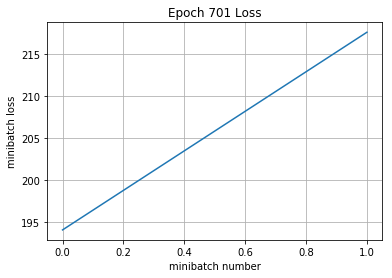

Epoch 702, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 703, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 704, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.99
Epoch 705, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 706, Overall loss = 0.0358, accuracy of 0.986 and f1 score of 0.98
Epoch 707, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 708, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 709, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 710, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 711, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.306, accuracy of 0.931 and f1 score of 0.933


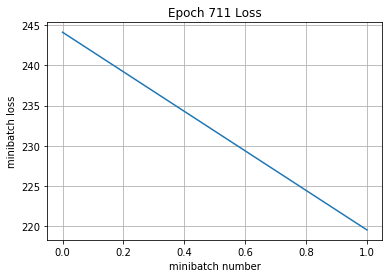

Epoch 712, Overall loss = 0.0413, accuracy of 0.985 and f1 score of 0.98
Epoch 713, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 714, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Epoch 715, Overall loss = 0.0407, accuracy of 0.985 and f1 score of 0.98
Epoch 716, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Epoch 717, Overall loss = 0.0381, accuracy of 0.985 and f1 score of 0.98
Epoch 718, Overall loss = 0.038, accuracy of 0.988 and f1 score of 0.99
Epoch 719, Overall loss = 0.0347, accuracy of 0.987 and f1 score of 0.99
Epoch 720, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Epoch 721, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.318, accuracy of 0.931 and f1 score of 0.935


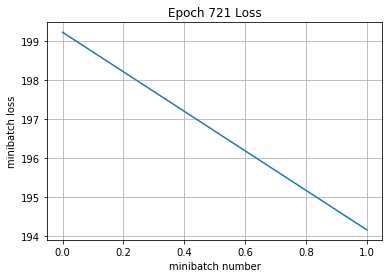

Epoch 722, Overall loss = 0.0398, accuracy of 0.987 and f1 score of 0.99
Epoch 723, Overall loss = 0.0371, accuracy of 0.988 and f1 score of 0.99
Epoch 724, Overall loss = 0.0392, accuracy of 0.987 and f1 score of 0.99
Epoch 725, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 726, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 727, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 728, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 729, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 730, Overall loss = 0.0368, accuracy of 0.988 and f1 score of 0.99
Epoch 731, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.928 and f1 score of 0.933


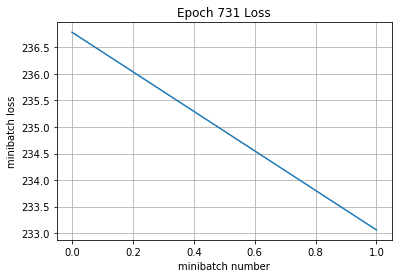

Epoch 732, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 733, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 734, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 735, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Epoch 736, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 737, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 738, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 739, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 740, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 741, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.315, accuracy of 0.929 and f1 score of 0.931


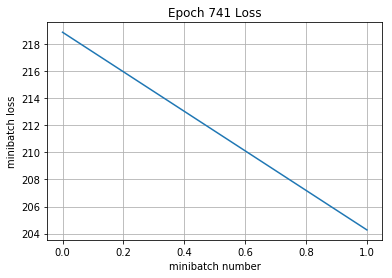

Epoch 742, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 743, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Epoch 744, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 745, Overall loss = 0.0362, accuracy of 0.988 and f1 score of 0.99
Epoch 746, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 747, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.99
Epoch 748, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 749, Overall loss = 0.0416, accuracy of 0.985 and f1 score of 0.98
Epoch 750, Overall loss = 0.0342, accuracy of 0.988 and f1 score of 0.99
Iteration 1500: with minibatch training loss = 0.0386, accuracy of 0.99, and f1 score of 0.99
Epoch 751, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.925 and f1 score of 0.929


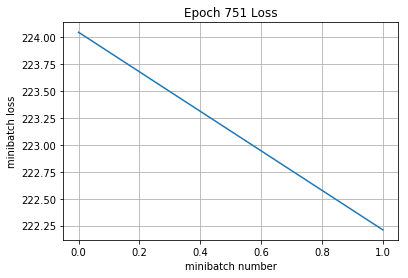

Epoch 752, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 753, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Epoch 754, Overall loss = 0.0416, accuracy of 0.986 and f1 score of 0.98
Epoch 755, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 756, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 757, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 758, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 759, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 760, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.98
Epoch 761, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.302, accuracy of 0.931 and f1 score of 0.934


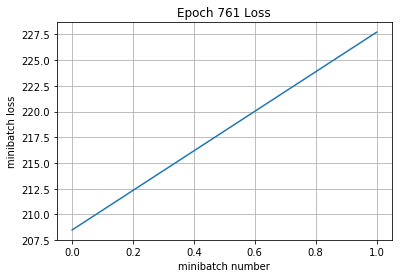

Epoch 762, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.98
Epoch 763, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 764, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.99
Epoch 765, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 766, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 767, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.99
Epoch 768, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 769, Overall loss = 0.0397, accuracy of 0.987 and f1 score of 0.99
Epoch 770, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 771, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.305, accuracy of 0.931 and f1 score of 0.934


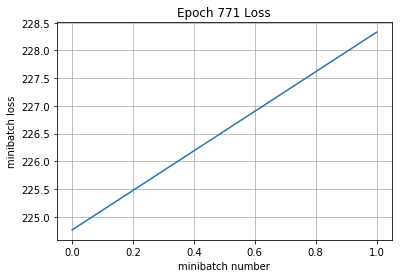

Epoch 772, Overall loss = 0.0389, accuracy of 0.985 and f1 score of 0.98
Epoch 773, Overall loss = 0.0396, accuracy of 0.984 and f1 score of 0.98
Epoch 774, Overall loss = 0.0386, accuracy of 0.985 and f1 score of 0.98
Epoch 775, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 776, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 777, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 778, Overall loss = 0.0408, accuracy of 0.986 and f1 score of 0.98
Epoch 779, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 780, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 781, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.314, accuracy of 0.93 and f1 score of 0.935


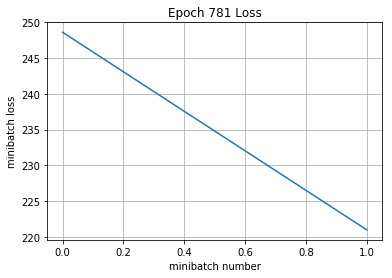

Epoch 782, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 783, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 784, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 785, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 786, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 787, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 788, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 789, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 790, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 791, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.316, accuracy of 0.931 and f1 score of 0.932


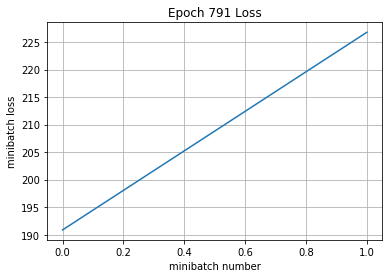

Epoch 792, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.99
Epoch 793, Overall loss = 0.0376, accuracy of 0.988 and f1 score of 0.99
Epoch 794, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 795, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 796, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 797, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 798, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 799, Overall loss = 0.0376, accuracy of 0.985 and f1 score of 0.98
Epoch 800, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Iteration 1600: with minibatch training loss = 0.0333, accuracy of 0.99, and f1 score of 0.99
Epoch 801, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.332, accuracy of 0.931 and f1 score of 0.932


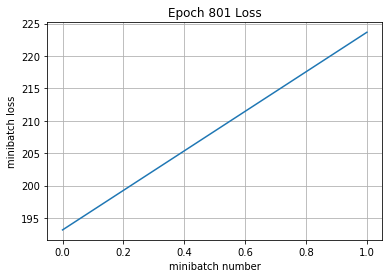

Epoch 802, Overall loss = 0.0404, accuracy of 0.984 and f1 score of 0.98
Epoch 803, Overall loss = 0.0387, accuracy of 0.985 and f1 score of 0.98
Epoch 804, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 805, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 806, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 807, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 808, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 809, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.99
Epoch 810, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 811, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.321, accuracy of 0.93 and f1 score of 0.933


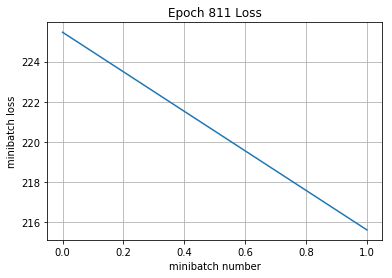

Epoch 812, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.99
Epoch 813, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 814, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 815, Overall loss = 0.0408, accuracy of 0.986 and f1 score of 0.98
Epoch 816, Overall loss = 0.0364, accuracy of 0.988 and f1 score of 0.99
Epoch 817, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 818, Overall loss = 0.0403, accuracy of 0.985 and f1 score of 0.98
Epoch 819, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 820, Overall loss = 0.0375, accuracy of 0.985 and f1 score of 0.98
Epoch 821, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.931 and f1 score of 0.93


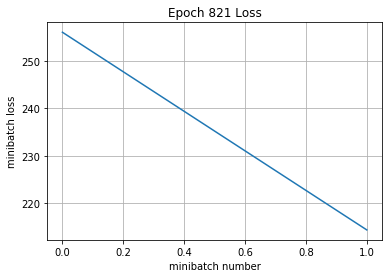

Epoch 822, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 823, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 824, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.98
Epoch 825, Overall loss = 0.0369, accuracy of 0.988 and f1 score of 0.99
Epoch 826, Overall loss = 0.041, accuracy of 0.985 and f1 score of 0.98
Epoch 827, Overall loss = 0.0399, accuracy of 0.985 and f1 score of 0.98
Epoch 828, Overall loss = 0.04, accuracy of 0.987 and f1 score of 0.99
Epoch 829, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 830, Overall loss = 0.033, accuracy of 0.988 and f1 score of 0.99
Epoch 831, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.309, accuracy of 0.93 and f1 score of 0.931


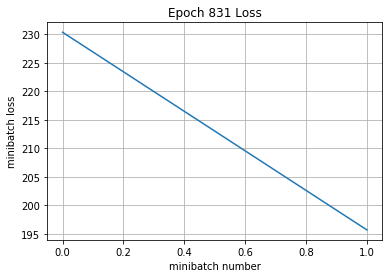

Epoch 832, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.98
Epoch 833, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 834, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Epoch 835, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.99
Epoch 836, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 837, Overall loss = 0.0371, accuracy of 0.988 and f1 score of 0.99
Epoch 838, Overall loss = 0.0383, accuracy of 0.985 and f1 score of 0.98
Epoch 839, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Epoch 840, Overall loss = 0.0374, accuracy of 0.985 and f1 score of 0.98
Epoch 841, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.317, accuracy of 0.928 and f1 score of 0.93


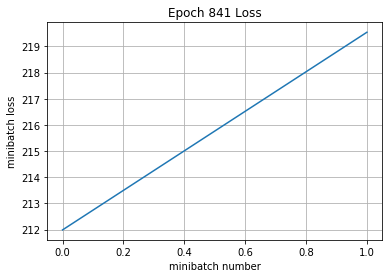

Epoch 842, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 843, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 844, Overall loss = 0.0401, accuracy of 0.986 and f1 score of 0.98
Epoch 845, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 846, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 847, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.98
Epoch 848, Overall loss = 0.0361, accuracy of 0.988 and f1 score of 0.99
Epoch 849, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 850, Overall loss = 0.034, accuracy of 0.989 and f1 score of 0.99
Iteration 1700: with minibatch training loss = 0.0424, accuracy of 0.98, and f1 score of 0.98
Epoch 851, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.929 and f1 score of 0.927


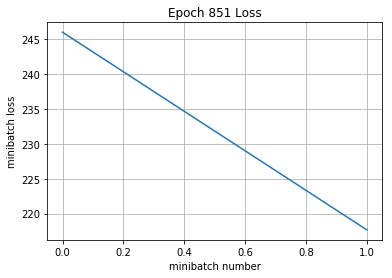

Epoch 852, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.99
Epoch 853, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 854, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 855, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 856, Overall loss = 0.0405, accuracy of 0.984 and f1 score of 0.98
Epoch 857, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.99
Epoch 858, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 859, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 860, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 861, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.32, accuracy of 0.929 and f1 score of 0.931


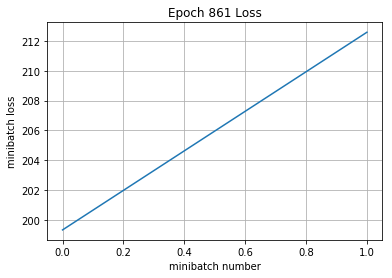

Epoch 862, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 863, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 864, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.99
Epoch 865, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 866, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 867, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Epoch 868, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 869, Overall loss = 0.0388, accuracy of 0.987 and f1 score of 0.99
Epoch 870, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 871, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.311, accuracy of 0.932 and f1 score of 0.935


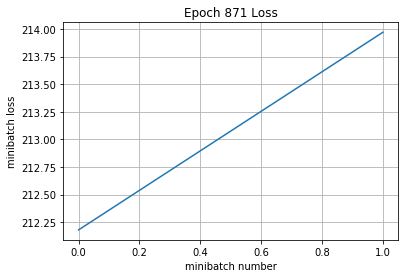

Epoch 872, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 873, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 874, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 875, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 876, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 877, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 878, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 879, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 880, Overall loss = 0.0403, accuracy of 0.985 and f1 score of 0.98
Epoch 881, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.311, accuracy of 0.934 and f1 score of 0.936


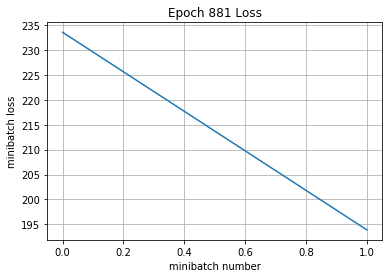

Epoch 882, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.99
Epoch 883, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.98
Epoch 884, Overall loss = 0.0398, accuracy of 0.987 and f1 score of 0.99
Epoch 885, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 886, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.99
Epoch 887, Overall loss = 0.0425, accuracy of 0.984 and f1 score of 0.98
Epoch 888, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.98
Epoch 889, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 890, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 891, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.929 and f1 score of 0.93


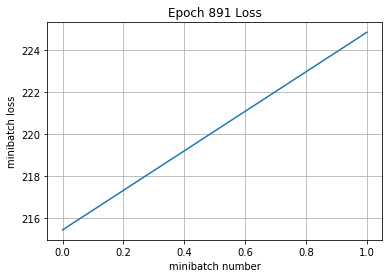

Epoch 892, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 893, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 894, Overall loss = 0.0343, accuracy of 0.987 and f1 score of 0.99
Epoch 895, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Epoch 896, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.99
Epoch 897, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 898, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 899, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Epoch 900, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Iteration 1800: with minibatch training loss = 0.0365, accuracy of 0.99, and f1 score of 0.98
Epoch 901, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.932 and f1 score of 0.934


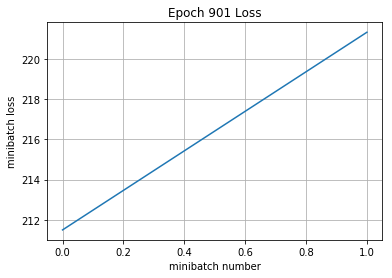

Epoch 902, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.99
Epoch 903, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 904, Overall loss = 0.0369, accuracy of 0.988 and f1 score of 0.99
Epoch 905, Overall loss = 0.0343, accuracy of 0.987 and f1 score of 0.99
Epoch 906, Overall loss = 0.0335, accuracy of 0.988 and f1 score of 0.99
Epoch 907, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.98
Epoch 908, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 909, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 910, Overall loss = 0.0381, accuracy of 0.988 and f1 score of 0.99
Epoch 911, Overall loss = 0.038, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.928 and f1 score of 0.931


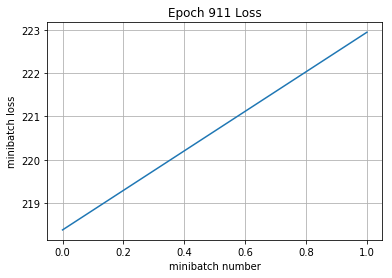

Epoch 912, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 913, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.99
Epoch 914, Overall loss = 0.0406, accuracy of 0.984 and f1 score of 0.98
Epoch 915, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 916, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Epoch 917, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 918, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 919, Overall loss = 0.0388, accuracy of 0.985 and f1 score of 0.98
Epoch 920, Overall loss = 0.0402, accuracy of 0.986 and f1 score of 0.98
Epoch 921, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.318, accuracy of 0.929 and f1 score of 0.932


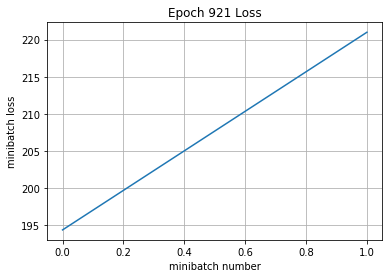

Epoch 922, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Epoch 923, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.98
Epoch 924, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 925, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 926, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 927, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 928, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 929, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.99
Epoch 930, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 931, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.316, accuracy of 0.931 and f1 score of 0.932


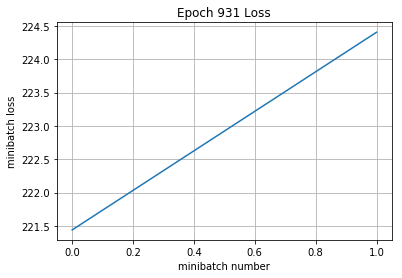

Epoch 932, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Epoch 933, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 934, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 935, Overall loss = 0.0362, accuracy of 0.986 and f1 score of 0.99
Epoch 936, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 937, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 938, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 939, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 940, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.99
Epoch 941, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.312, accuracy of 0.93 and f1 score of 0.932


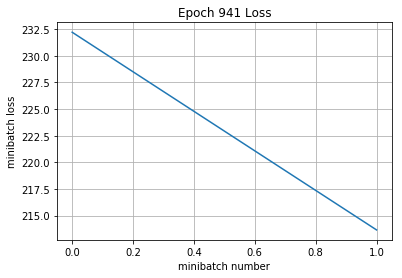

Epoch 942, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 943, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 944, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 945, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 946, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 947, Overall loss = 0.0356, accuracy of 0.988 and f1 score of 0.99
Epoch 948, Overall loss = 0.0419, accuracy of 0.985 and f1 score of 0.98
Epoch 949, Overall loss = 0.0371, accuracy of 0.988 and f1 score of 0.99
Epoch 950, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Iteration 1900: with minibatch training loss = 0.0381, accuracy of 0.99, and f1 score of 0.99
Epoch 951, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.306, accuracy of 0.93 and f1 score of 0.93


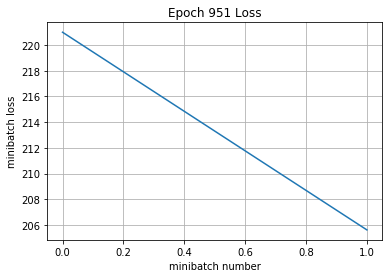

Epoch 952, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 953, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 954, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 955, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 956, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.98
Epoch 957, Overall loss = 0.0399, accuracy of 0.985 and f1 score of 0.98
Epoch 958, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 959, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 960, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 961, Overall loss = 0.0358, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.328, accuracy of 0.928 and f1 score of 0.931


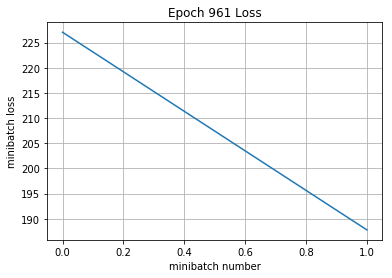

Epoch 962, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 963, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 964, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 965, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 966, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 967, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 968, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.99
Epoch 969, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 970, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.99
Epoch 971, Overall loss = 0.0405, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.321, accuracy of 0.928 and f1 score of 0.929


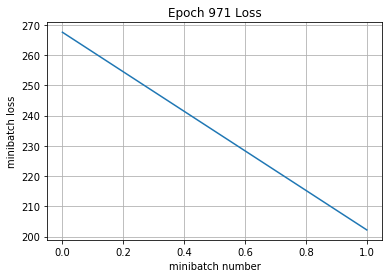

Epoch 972, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 973, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.98
Epoch 974, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 975, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Epoch 976, Overall loss = 0.0414, accuracy of 0.985 and f1 score of 0.98
Epoch 977, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 978, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 979, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 980, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 981, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.93 and f1 score of 0.934


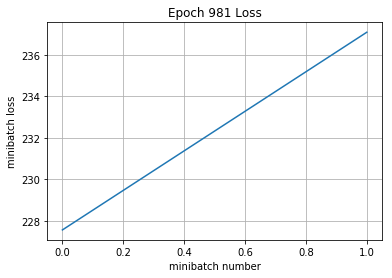

Epoch 982, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.98
Epoch 983, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 984, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 985, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 986, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 987, Overall loss = 0.0344, accuracy of 0.988 and f1 score of 0.99
Epoch 988, Overall loss = 0.037, accuracy of 0.988 and f1 score of 0.99
Epoch 989, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 990, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.99
Epoch 991, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.325, accuracy of 0.929 and f1 score of 0.932


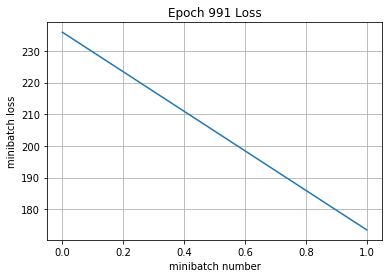

Epoch 992, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 993, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 994, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 995, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 996, Overall loss = 0.035, accuracy of 0.987 and f1 score of 0.98
Epoch 997, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 998, Overall loss = 0.0393, accuracy of 0.987 and f1 score of 0.99
Epoch 999, Overall loss = 0.0342, accuracy of 0.988 and f1 score of 0.99
Epoch 1000, Overall loss = 0.035, accuracy of 0.987 and f1 score of 0.99
Iteration 2000: with minibatch training loss = 0.0366, accuracy of 0.99, and f1 score of 0.98
Epoch 1001, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.31, accuracy of 0.931 and f1 score of 0.934


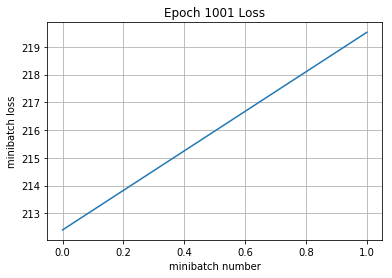

Epoch 1002, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1003, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1004, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1005, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.99
Epoch 1006, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.99
Epoch 1007, Overall loss = 0.0398, accuracy of 0.985 and f1 score of 0.98
Epoch 1008, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1009, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.98
Epoch 1010, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 1011, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.315, accuracy of 0.927 and f1 score of 0.931


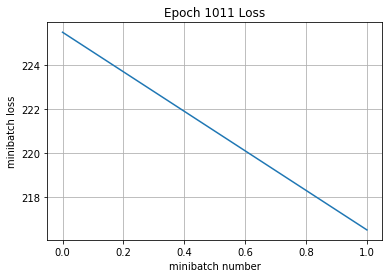

Epoch 1012, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.98
Epoch 1013, Overall loss = 0.0413, accuracy of 0.985 and f1 score of 0.98
Epoch 1014, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.98
Epoch 1015, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1016, Overall loss = 0.0395, accuracy of 0.985 and f1 score of 0.98
Epoch 1017, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 1018, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.98
Epoch 1019, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1020, Overall loss = 0.0356, accuracy of 0.988 and f1 score of 0.99
Epoch 1021, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.329, accuracy of 0.926 and f1 score of 0.928


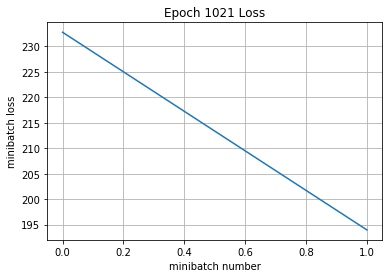

Epoch 1022, Overall loss = 0.0379, accuracy of 0.985 and f1 score of 0.98
Epoch 1023, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 1024, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1025, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 1026, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 1027, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 1028, Overall loss = 0.0412, accuracy of 0.985 and f1 score of 0.98
Epoch 1029, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1030, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Epoch 1031, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.306, accuracy of 0.931 and f1 score of 0.932


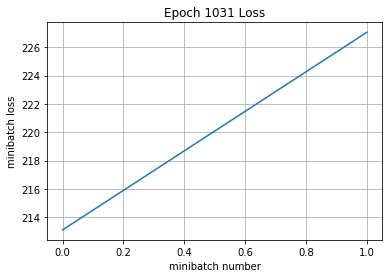

Epoch 1032, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1033, Overall loss = 0.0405, accuracy of 0.984 and f1 score of 0.98
Epoch 1034, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 1035, Overall loss = 0.0328, accuracy of 0.989 and f1 score of 0.99
Epoch 1036, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 1037, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1038, Overall loss = 0.0391, accuracy of 0.987 and f1 score of 0.99
Epoch 1039, Overall loss = 0.037, accuracy of 0.988 and f1 score of 0.99
Epoch 1040, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 1041, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.932 and f1 score of 0.934


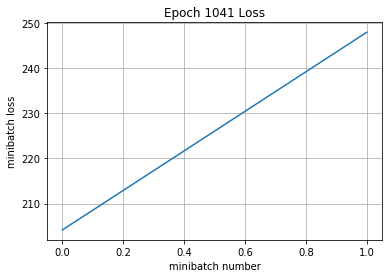

Epoch 1042, Overall loss = 0.0399, accuracy of 0.987 and f1 score of 0.99
Epoch 1043, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.99
Epoch 1044, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1045, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 1046, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 1047, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.99
Epoch 1048, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1049, Overall loss = 0.0358, accuracy of 0.988 and f1 score of 0.99
Epoch 1050, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Iteration 2100: with minibatch training loss = 0.0339, accuracy of 0.99, and f1 score of 0.99
Epoch 1051, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.325, accuracy of 0.928 and f1 score of 0.929


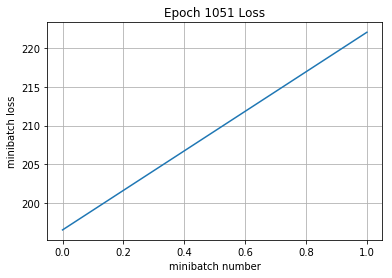

Epoch 1052, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 1053, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1054, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1055, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1056, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Epoch 1057, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 1058, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1059, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1060, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 1061, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.927 and f1 score of 0.93


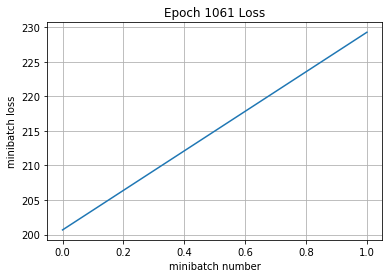

Epoch 1062, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1063, Overall loss = 0.0401, accuracy of 0.986 and f1 score of 0.98
Epoch 1064, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1065, Overall loss = 0.0364, accuracy of 0.986 and f1 score of 0.98
Epoch 1066, Overall loss = 0.0328, accuracy of 0.988 and f1 score of 0.99
Epoch 1067, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 1068, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1069, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 1070, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.98
Epoch 1071, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.93 and f1 score of 0.934


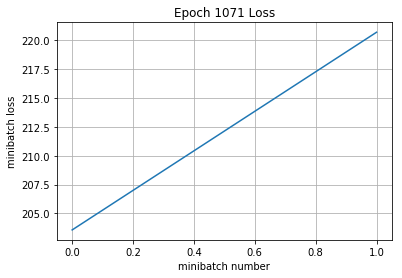

Epoch 1072, Overall loss = 0.0379, accuracy of 0.985 and f1 score of 0.98
Epoch 1073, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Epoch 1074, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 1075, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 1076, Overall loss = 0.0342, accuracy of 0.987 and f1 score of 0.99
Epoch 1077, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1078, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1079, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 1080, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1081, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.329, accuracy of 0.929 and f1 score of 0.931


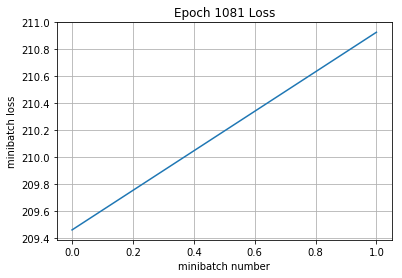

Epoch 1082, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 1083, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.99
Epoch 1084, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 1085, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 1086, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 1087, Overall loss = 0.035, accuracy of 0.987 and f1 score of 0.99
Epoch 1088, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1089, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1090, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 1091, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.319, accuracy of 0.927 and f1 score of 0.929


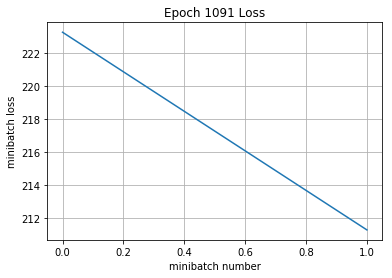

Epoch 1092, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 1093, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.99
Epoch 1094, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.99
Epoch 1095, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1096, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.98
Epoch 1097, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1098, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.98
Epoch 1099, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1100, Overall loss = 0.035, accuracy of 0.987 and f1 score of 0.99
Iteration 2200: with minibatch training loss = 0.0378, accuracy of 0.99, and f1 score of 0.99
Epoch 1101, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.303, accuracy of 0.931 and f1 score of 0.935


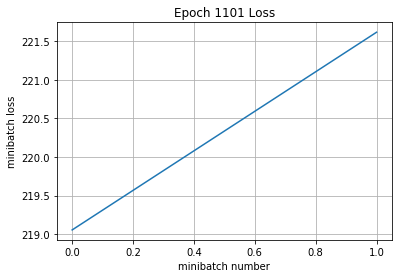

Epoch 1102, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.99
Epoch 1103, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 1104, Overall loss = 0.0343, accuracy of 0.987 and f1 score of 0.99
Epoch 1105, Overall loss = 0.0342, accuracy of 0.987 and f1 score of 0.98
Epoch 1106, Overall loss = 0.0351, accuracy of 0.989 and f1 score of 0.99
Epoch 1107, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1108, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1109, Overall loss = 0.0406, accuracy of 0.985 and f1 score of 0.98
Epoch 1110, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1111, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.931 and f1 score of 0.937


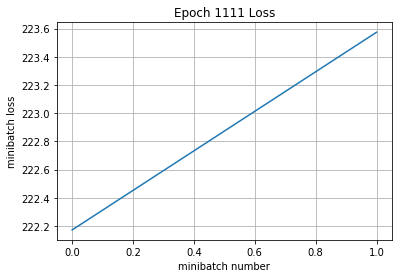

Epoch 1112, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1113, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.98
Epoch 1114, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 1115, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 1116, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Epoch 1117, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1118, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.99
Epoch 1119, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 1120, Overall loss = 0.0409, accuracy of 0.986 and f1 score of 0.98
Epoch 1121, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.931 and f1 score of 0.934


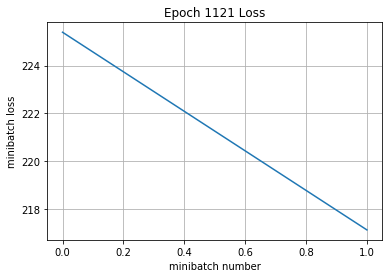

Epoch 1122, Overall loss = 0.0419, accuracy of 0.985 and f1 score of 0.98
Epoch 1123, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 1124, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.99
Epoch 1125, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1126, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 1127, Overall loss = 0.0354, accuracy of 0.986 and f1 score of 0.98
Epoch 1128, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.99
Epoch 1129, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 1130, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Epoch 1131, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.929 and f1 score of 0.93


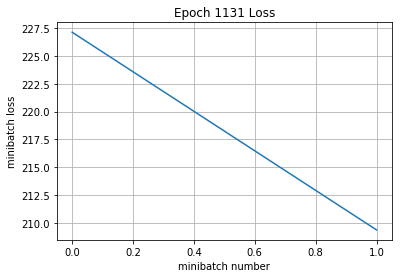

Epoch 1132, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.99
Epoch 1133, Overall loss = 0.0344, accuracy of 0.988 and f1 score of 0.99
Epoch 1134, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1135, Overall loss = 0.0397, accuracy of 0.986 and f1 score of 0.99
Epoch 1136, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 1137, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.99
Epoch 1138, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 1139, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.98
Epoch 1140, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 1141, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.93 and f1 score of 0.931


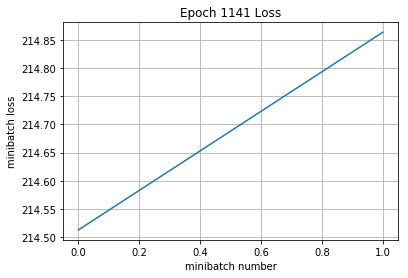

Epoch 1142, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.98
Epoch 1143, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 1144, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 1145, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.98
Epoch 1146, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 1147, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1148, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1149, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 1150, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Iteration 2300: with minibatch training loss = 0.0374, accuracy of 0.99, and f1 score of 0.99
Epoch 1151, Overall loss = 0.0373, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.93 and f1 score of 0.931


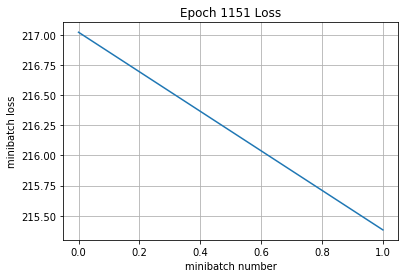

Epoch 1152, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 1153, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1154, Overall loss = 0.0375, accuracy of 0.985 and f1 score of 0.98
Epoch 1155, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.98
Epoch 1156, Overall loss = 0.0399, accuracy of 0.986 and f1 score of 0.98
Epoch 1157, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.99
Epoch 1158, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.98
Epoch 1159, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.99
Epoch 1160, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1161, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.32, accuracy of 0.931 and f1 score of 0.932


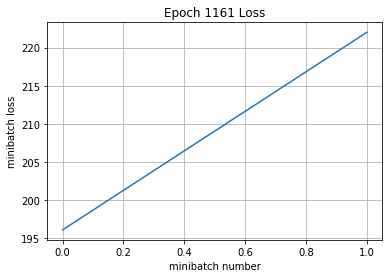

Epoch 1162, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1163, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 1164, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1165, Overall loss = 0.0356, accuracy of 0.986 and f1 score of 0.98
Epoch 1166, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1167, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.98
Epoch 1168, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1169, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 1170, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1171, Overall loss = 0.0372, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.926 and f1 score of 0.927


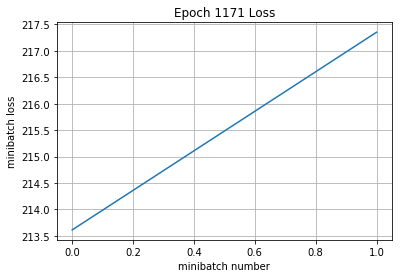

Epoch 1172, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1173, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 1174, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1175, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1176, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Epoch 1177, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 1178, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.99
Epoch 1179, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1180, Overall loss = 0.0409, accuracy of 0.985 and f1 score of 0.98
Epoch 1181, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.934 and f1 score of 0.937


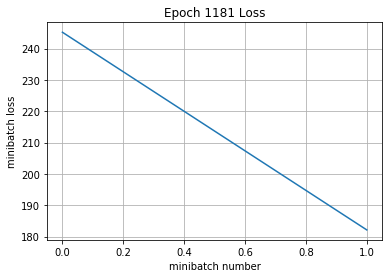

Epoch 1182, Overall loss = 0.0349, accuracy of 0.986 and f1 score of 0.98
Epoch 1183, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Epoch 1184, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1185, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1186, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1187, Overall loss = 0.0361, accuracy of 0.988 and f1 score of 0.99
Epoch 1188, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1189, Overall loss = 0.0365, accuracy of 0.986 and f1 score of 0.98
Epoch 1190, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 1191, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.319, accuracy of 0.931 and f1 score of 0.933


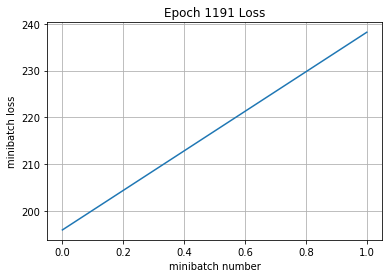

Epoch 1192, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Epoch 1193, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1194, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1195, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 1196, Overall loss = 0.0387, accuracy of 0.985 and f1 score of 0.98
Epoch 1197, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.98
Epoch 1198, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 1199, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 1200, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.99
Iteration 2400: with minibatch training loss = 0.0364, accuracy of 0.99, and f1 score of 0.99
Epoch 1201, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.311, accuracy of 0.932 and f1 score of 0.934


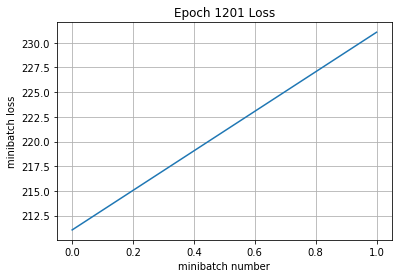

Epoch 1202, Overall loss = 0.0377, accuracy of 0.988 and f1 score of 0.99
Epoch 1203, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.98
Epoch 1204, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Epoch 1205, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 1206, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 1207, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1208, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1209, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1210, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1211, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.306, accuracy of 0.932 and f1 score of 0.934


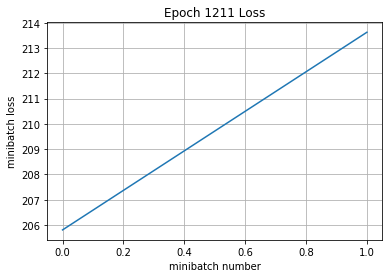

Epoch 1212, Overall loss = 0.0404, accuracy of 0.985 and f1 score of 0.98
Epoch 1213, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 1214, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 1215, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 1216, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1217, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 1218, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.98
Epoch 1219, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1220, Overall loss = 0.0372, accuracy of 0.988 and f1 score of 0.99
Epoch 1221, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.317, accuracy of 0.929 and f1 score of 0.932


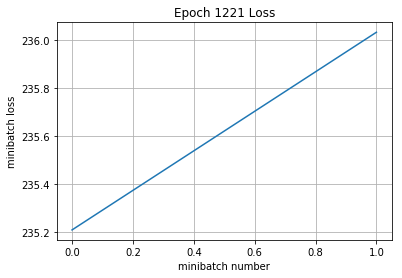

Epoch 1222, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1223, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1224, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1225, Overall loss = 0.0365, accuracy of 0.986 and f1 score of 0.98
Epoch 1226, Overall loss = 0.0337, accuracy of 0.987 and f1 score of 0.99
Epoch 1227, Overall loss = 0.0384, accuracy of 0.985 and f1 score of 0.98
Epoch 1228, Overall loss = 0.0412, accuracy of 0.985 and f1 score of 0.98
Epoch 1229, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 1230, Overall loss = 0.0353, accuracy of 0.986 and f1 score of 0.99
Epoch 1231, Overall loss = 0.0347, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.314, accuracy of 0.93 and f1 score of 0.933


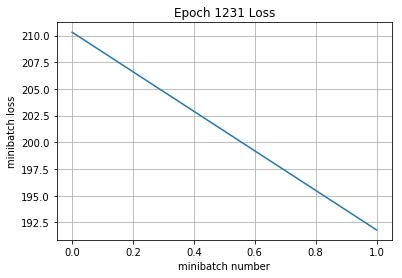

Epoch 1232, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.99
Epoch 1233, Overall loss = 0.0325, accuracy of 0.989 and f1 score of 0.99
Epoch 1234, Overall loss = 0.0334, accuracy of 0.988 and f1 score of 0.99
Epoch 1235, Overall loss = 0.0385, accuracy of 0.985 and f1 score of 0.98
Epoch 1236, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 1237, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Epoch 1238, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.99
Epoch 1239, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.99
Epoch 1240, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 1241, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.314, accuracy of 0.929 and f1 score of 0.932


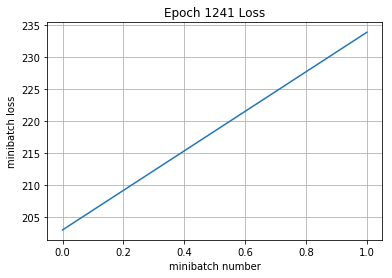

Epoch 1242, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 1243, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 1244, Overall loss = 0.039, accuracy of 0.987 and f1 score of 0.98
Epoch 1245, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 1246, Overall loss = 0.0343, accuracy of 0.989 and f1 score of 0.99
Epoch 1247, Overall loss = 0.0376, accuracy of 0.988 and f1 score of 0.99
Epoch 1248, Overall loss = 0.0336, accuracy of 0.988 and f1 score of 0.99
Epoch 1249, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1250, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.98
Iteration 2500: with minibatch training loss = 0.0386, accuracy of 0.99, and f1 score of 0.98
Epoch 1251, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.307, accuracy of 0.934 and f1 score of 0.936


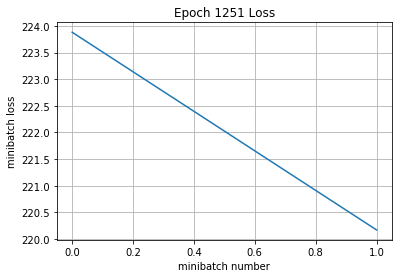

Epoch 1252, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.99
Epoch 1253, Overall loss = 0.0407, accuracy of 0.986 and f1 score of 0.98
Epoch 1254, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 1255, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 1256, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1257, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1258, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 1259, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.99
Epoch 1260, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Epoch 1261, Overall loss = 0.0386, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.319, accuracy of 0.929 and f1 score of 0.932


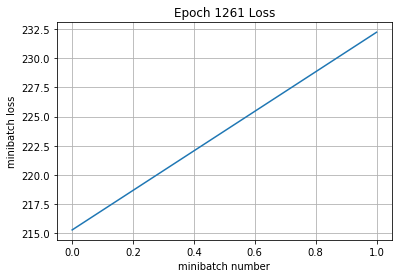

Epoch 1262, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 1263, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1264, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 1265, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 1266, Overall loss = 0.0408, accuracy of 0.985 and f1 score of 0.98
Epoch 1267, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.98
Epoch 1268, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.98
Epoch 1269, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 1270, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 1271, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.32, accuracy of 0.929 and f1 score of 0.931


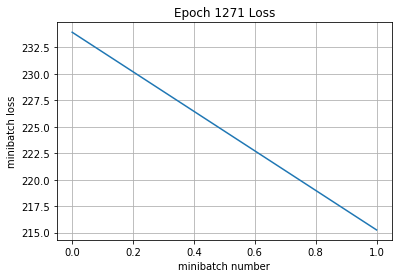

Epoch 1272, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.99
Epoch 1273, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 1274, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 1275, Overall loss = 0.0396, accuracy of 0.986 and f1 score of 0.98
Epoch 1276, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 1277, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1278, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1279, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1280, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 1281, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.328, accuracy of 0.929 and f1 score of 0.93


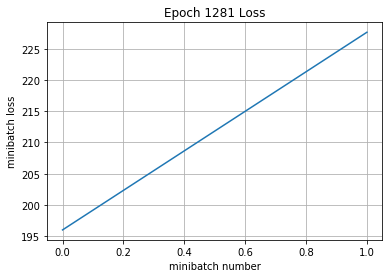

Epoch 1282, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 1283, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 1284, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1285, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 1286, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 1287, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1288, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.99
Epoch 1289, Overall loss = 0.037, accuracy of 0.988 and f1 score of 0.99
Epoch 1290, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1291, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.312, accuracy of 0.932 and f1 score of 0.933


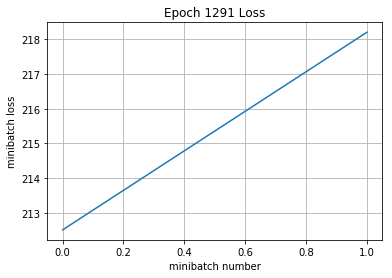

Epoch 1292, Overall loss = 0.039, accuracy of 0.985 and f1 score of 0.98
Epoch 1293, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1294, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1295, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1296, Overall loss = 0.0353, accuracy of 0.986 and f1 score of 0.99
Epoch 1297, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 1298, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1299, Overall loss = 0.0397, accuracy of 0.985 and f1 score of 0.98
Epoch 1300, Overall loss = 0.0359, accuracy of 0.986 and f1 score of 0.98
Iteration 2600: with minibatch training loss = 0.0333, accuracy of 0.99, and f1 score of 0.99
Epoch 1301, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.314, accuracy of 0.93 and f1 score of 0.93


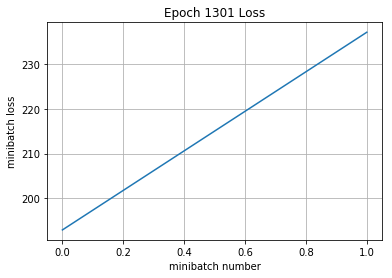

Epoch 1302, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 1303, Overall loss = 0.0345, accuracy of 0.989 and f1 score of 0.99
Epoch 1304, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 1305, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.99
Epoch 1306, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 1307, Overall loss = 0.0338, accuracy of 0.987 and f1 score of 0.99
Epoch 1308, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 1309, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 1310, Overall loss = 0.0353, accuracy of 0.989 and f1 score of 0.99
Epoch 1311, Overall loss = 0.04, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.322, accuracy of 0.931 and f1 score of 0.933


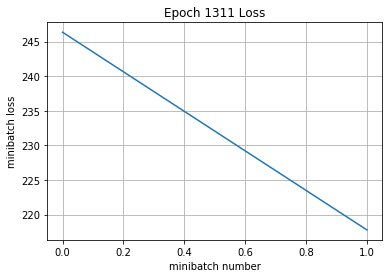

Epoch 1312, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 1313, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 1314, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.98
Epoch 1315, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1316, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1317, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Epoch 1318, Overall loss = 0.0383, accuracy of 0.985 and f1 score of 0.98
Epoch 1319, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1320, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.98
Epoch 1321, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.321, accuracy of 0.931 and f1 score of 0.935


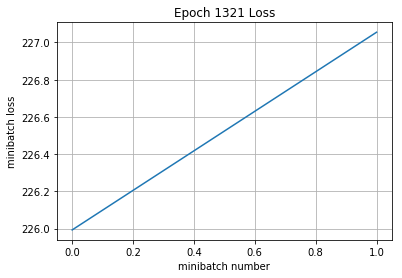

Epoch 1322, Overall loss = 0.0364, accuracy of 0.988 and f1 score of 0.99
Epoch 1323, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.99
Epoch 1324, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1325, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1326, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 1327, Overall loss = 0.0392, accuracy of 0.985 and f1 score of 0.98
Epoch 1328, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 1329, Overall loss = 0.0374, accuracy of 0.988 and f1 score of 0.99
Epoch 1330, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 1331, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.93 and f1 score of 0.932


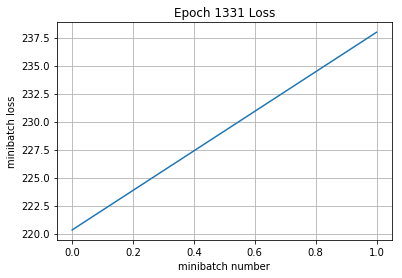

Epoch 1332, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.99
Epoch 1333, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 1334, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 1335, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1336, Overall loss = 0.0361, accuracy of 0.988 and f1 score of 0.99
Epoch 1337, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 1338, Overall loss = 0.0353, accuracy of 0.986 and f1 score of 0.99
Epoch 1339, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1340, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1341, Overall loss = 0.037, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.309, accuracy of 0.932 and f1 score of 0.934


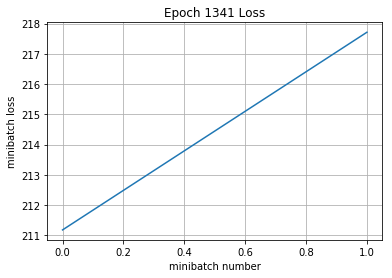

Epoch 1342, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1343, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1344, Overall loss = 0.0388, accuracy of 0.985 and f1 score of 0.98
Epoch 1345, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.99
Epoch 1346, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1347, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.99
Epoch 1348, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1349, Overall loss = 0.0364, accuracy of 0.988 and f1 score of 0.99
Epoch 1350, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.99
Iteration 2700: with minibatch training loss = 0.0396, accuracy of 0.99, and f1 score of 0.98
Epoch 1351, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.307, accuracy of 0.934 and f1 score of 0.938


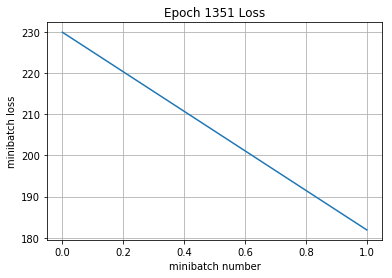

Epoch 1352, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 1353, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Epoch 1354, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1355, Overall loss = 0.036, accuracy of 0.986 and f1 score of 0.98
Epoch 1356, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.99
Epoch 1357, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 1358, Overall loss = 0.034, accuracy of 0.987 and f1 score of 0.99
Epoch 1359, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.99
Epoch 1360, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.98
Epoch 1361, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.925 and f1 score of 0.927


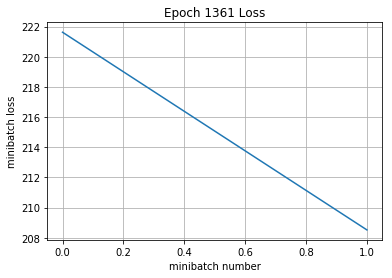

Epoch 1362, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1363, Overall loss = 0.0409, accuracy of 0.986 and f1 score of 0.98
Epoch 1364, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 1365, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 1366, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1367, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.99
Epoch 1368, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1369, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1370, Overall loss = 0.0374, accuracy of 0.985 and f1 score of 0.98
Epoch 1371, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.314, accuracy of 0.932 and f1 score of 0.935


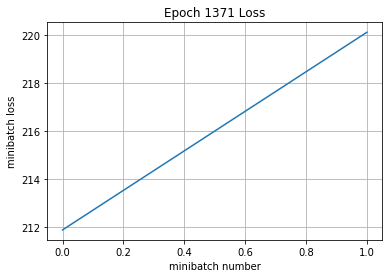

Epoch 1372, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1373, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1374, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 1375, Overall loss = 0.0344, accuracy of 0.987 and f1 score of 0.99
Epoch 1376, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 1377, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 1378, Overall loss = 0.035, accuracy of 0.987 and f1 score of 0.99
Epoch 1379, Overall loss = 0.0338, accuracy of 0.988 and f1 score of 0.99
Epoch 1380, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 1381, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.323, accuracy of 0.928 and f1 score of 0.928


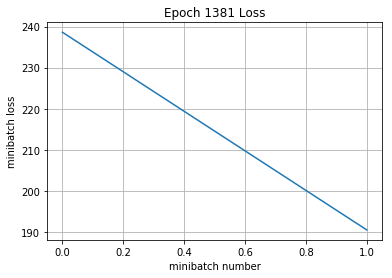

Epoch 1382, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 1383, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1384, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Epoch 1385, Overall loss = 0.0336, accuracy of 0.986 and f1 score of 0.98
Epoch 1386, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1387, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1388, Overall loss = 0.0391, accuracy of 0.985 and f1 score of 0.98
Epoch 1389, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1390, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.99
Epoch 1391, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.34, accuracy of 0.926 and f1 score of 0.929


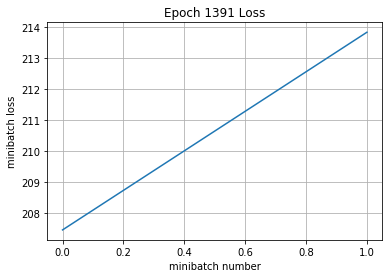

Epoch 1392, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1393, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1394, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.98
Epoch 1395, Overall loss = 0.0362, accuracy of 0.986 and f1 score of 0.99
Epoch 1396, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.99
Epoch 1397, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1398, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1399, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 1400, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Iteration 2800: with minibatch training loss = 0.0435, accuracy of 0.98, and f1 score of 0.98
Epoch 1401, Overall loss = 0.0394, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.317, accuracy of 0.93 and f1 score of 0.935


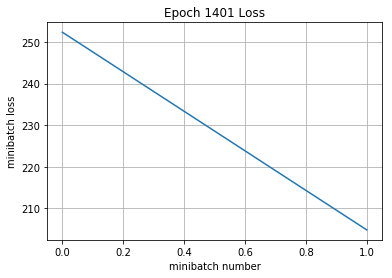

Epoch 1402, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 1403, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1404, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 1405, Overall loss = 0.039, accuracy of 0.985 and f1 score of 0.98
Epoch 1406, Overall loss = 0.041, accuracy of 0.986 and f1 score of 0.99
Epoch 1407, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1408, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 1409, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.98
Epoch 1410, Overall loss = 0.0406, accuracy of 0.986 and f1 score of 0.98
Epoch 1411, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.312, accuracy of 0.931 and f1 score of 0.932


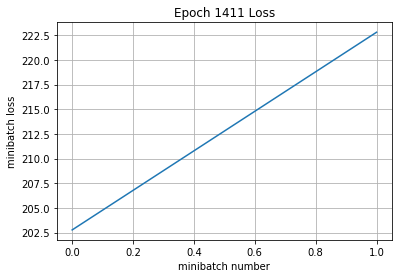

Epoch 1412, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Epoch 1413, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 1414, Overall loss = 0.0382, accuracy of 0.988 and f1 score of 0.99
Epoch 1415, Overall loss = 0.0385, accuracy of 0.985 and f1 score of 0.98
Epoch 1416, Overall loss = 0.034, accuracy of 0.989 and f1 score of 0.99
Epoch 1417, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1418, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.99
Epoch 1419, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1420, Overall loss = 0.0356, accuracy of 0.988 and f1 score of 0.99
Epoch 1421, Overall loss = 0.0389, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.335, accuracy of 0.931 and f1 score of 0.933


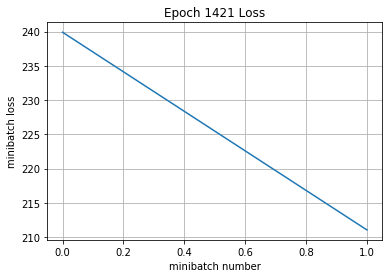

Epoch 1422, Overall loss = 0.0364, accuracy of 0.988 and f1 score of 0.99
Epoch 1423, Overall loss = 0.0366, accuracy of 0.988 and f1 score of 0.99
Epoch 1424, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1425, Overall loss = 0.0338, accuracy of 0.989 and f1 score of 0.99
Epoch 1426, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1427, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 1428, Overall loss = 0.036, accuracy of 0.986 and f1 score of 0.98
Epoch 1429, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.99
Epoch 1430, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.98
Epoch 1431, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.325, accuracy of 0.932 and f1 score of 0.936


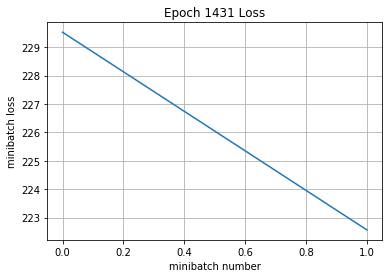

Epoch 1432, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1433, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1434, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Epoch 1435, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1436, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1437, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 1438, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1439, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Epoch 1440, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 1441, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.329, accuracy of 0.93 and f1 score of 0.932


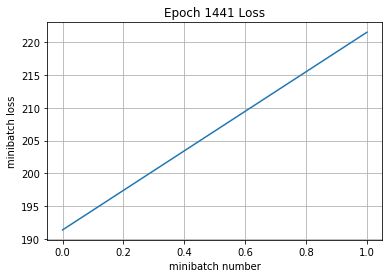

Epoch 1442, Overall loss = 0.0386, accuracy of 0.988 and f1 score of 0.99
Epoch 1443, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1444, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 1445, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 1446, Overall loss = 0.038, accuracy of 0.987 and f1 score of 0.98
Epoch 1447, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 1448, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1449, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1450, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Iteration 2900: with minibatch training loss = 0.0398, accuracy of 0.99, and f1 score of 0.98
Epoch 1451, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.322, accuracy of 0.928 and f1 score of 0.928


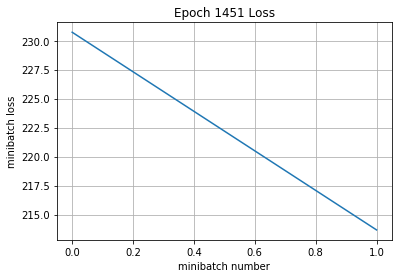

Epoch 1452, Overall loss = 0.0396, accuracy of 0.985 and f1 score of 0.98
Epoch 1453, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 1454, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1455, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1456, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Epoch 1457, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Epoch 1458, Overall loss = 0.036, accuracy of 0.986 and f1 score of 0.98
Epoch 1459, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Epoch 1460, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1461, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.321, accuracy of 0.928 and f1 score of 0.929


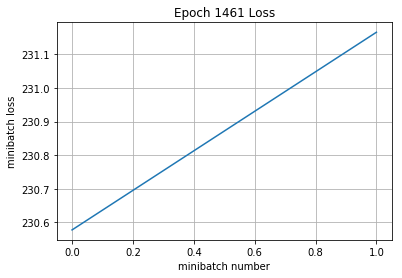

Epoch 1462, Overall loss = 0.0329, accuracy of 0.988 and f1 score of 0.99
Epoch 1463, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.98
Epoch 1464, Overall loss = 0.034, accuracy of 0.988 and f1 score of 0.99
Epoch 1465, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1466, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Epoch 1467, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 1468, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 1469, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1470, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1471, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.331, accuracy of 0.931 and f1 score of 0.933


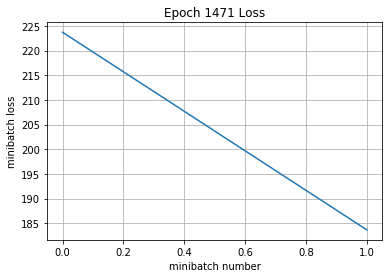

Epoch 1472, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Epoch 1473, Overall loss = 0.0368, accuracy of 0.988 and f1 score of 0.99
Epoch 1474, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 1475, Overall loss = 0.0342, accuracy of 0.987 and f1 score of 0.99
Epoch 1476, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 1477, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.98
Epoch 1478, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1479, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1480, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1481, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.928 and f1 score of 0.93


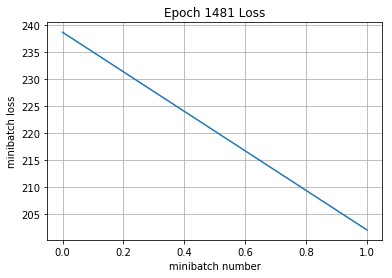

Epoch 1482, Overall loss = 0.0344, accuracy of 0.988 and f1 score of 0.99
Epoch 1483, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1484, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1485, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1486, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.99
Epoch 1487, Overall loss = 0.0342, accuracy of 0.987 and f1 score of 0.99
Epoch 1488, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1489, Overall loss = 0.0388, accuracy of 0.986 and f1 score of 0.98
Epoch 1490, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1491, Overall loss = 0.0384, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.931 and f1 score of 0.931


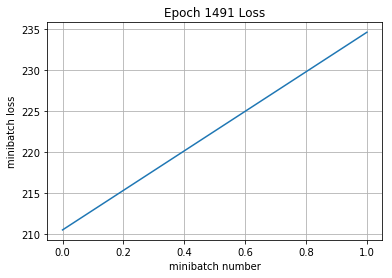

Epoch 1492, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 1493, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1494, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1495, Overall loss = 0.0358, accuracy of 0.986 and f1 score of 0.99
Epoch 1496, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.98
Epoch 1497, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 1498, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.98
Epoch 1499, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Epoch 1500, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.99
Iteration 3000: with minibatch training loss = 0.0374, accuracy of 0.99, and f1 score of 0.98
Epoch 1501, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.304, accuracy of 0.93 and f1 score of 0.932


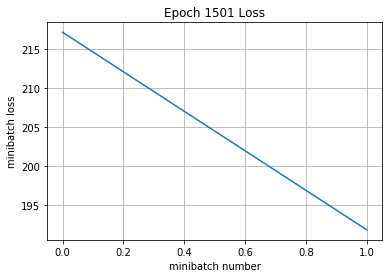

Epoch 1502, Overall loss = 0.0344, accuracy of 0.987 and f1 score of 0.99
Epoch 1503, Overall loss = 0.0366, accuracy of 0.988 and f1 score of 0.99
Epoch 1504, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.98
Epoch 1505, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1506, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Epoch 1507, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1508, Overall loss = 0.0358, accuracy of 0.988 and f1 score of 0.99
Epoch 1509, Overall loss = 0.0393, accuracy of 0.987 and f1 score of 0.98
Epoch 1510, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1511, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.335, accuracy of 0.927 and f1 score of 0.928


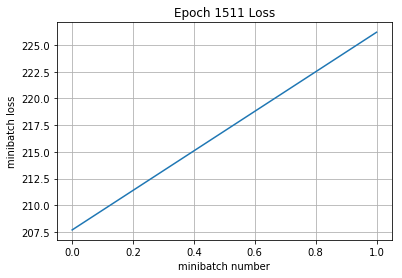

Epoch 1512, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 1513, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.99
Epoch 1514, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 1515, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1516, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1517, Overall loss = 0.0351, accuracy of 0.986 and f1 score of 0.98
Epoch 1518, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.98
Epoch 1519, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1520, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 1521, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.335, accuracy of 0.93 and f1 score of 0.93


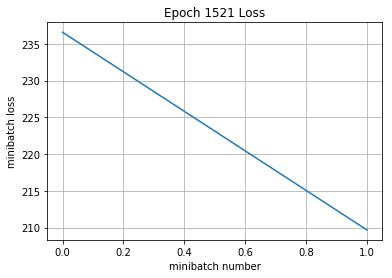

Epoch 1522, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1523, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1524, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1525, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.98
Epoch 1526, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1527, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1528, Overall loss = 0.0412, accuracy of 0.986 and f1 score of 0.98
Epoch 1529, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1530, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 1531, Overall loss = 0.0342, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.32, accuracy of 0.932 and f1 score of 0.935


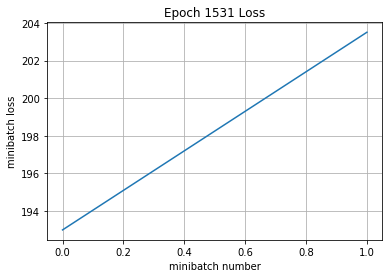

Epoch 1532, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.98
Epoch 1533, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 1534, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1535, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Epoch 1536, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Epoch 1537, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Epoch 1538, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 1539, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1540, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1541, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.93 and f1 score of 0.93


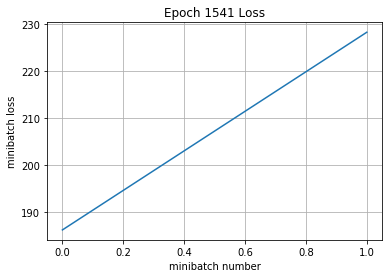

Epoch 1542, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Epoch 1543, Overall loss = 0.0364, accuracy of 0.986 and f1 score of 0.98
Epoch 1544, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1545, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 1546, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.98
Epoch 1547, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 1548, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 1549, Overall loss = 0.037, accuracy of 0.988 and f1 score of 0.99
Epoch 1550, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Iteration 3100: with minibatch training loss = 0.034, accuracy of 0.99, and f1 score of 0.98
Epoch 1551, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.318, accuracy of 0.927 and f1 score of 0.928


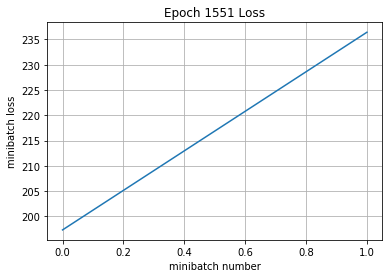

Epoch 1552, Overall loss = 0.0395, accuracy of 0.985 and f1 score of 0.98
Epoch 1553, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.99
Epoch 1554, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1555, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 1556, Overall loss = 0.0349, accuracy of 0.986 and f1 score of 0.99
Epoch 1557, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 1558, Overall loss = 0.0365, accuracy of 0.986 and f1 score of 0.98
Epoch 1559, Overall loss = 0.034, accuracy of 0.988 and f1 score of 0.99
Epoch 1560, Overall loss = 0.0388, accuracy of 0.987 and f1 score of 0.99
Epoch 1561, Overall loss = 0.0365, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.316, accuracy of 0.93 and f1 score of 0.932


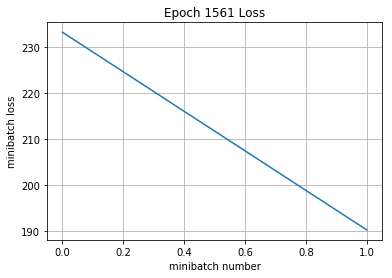

Epoch 1562, Overall loss = 0.0387, accuracy of 0.985 and f1 score of 0.98
Epoch 1563, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 1564, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1565, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.99
Epoch 1566, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1567, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 1568, Overall loss = 0.0344, accuracy of 0.988 and f1 score of 0.99
Epoch 1569, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 1570, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 1571, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.309, accuracy of 0.929 and f1 score of 0.931


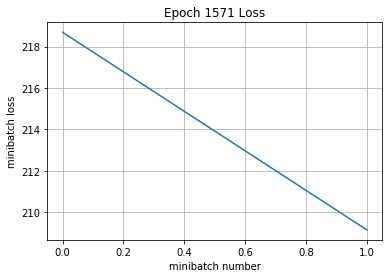

Epoch 1572, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1573, Overall loss = 0.0336, accuracy of 0.986 and f1 score of 0.99
Epoch 1574, Overall loss = 0.0332, accuracy of 0.988 and f1 score of 0.99
Epoch 1575, Overall loss = 0.0393, accuracy of 0.985 and f1 score of 0.98
Epoch 1576, Overall loss = 0.04, accuracy of 0.986 and f1 score of 0.99
Epoch 1577, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 1578, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 1579, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 1580, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1581, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.325, accuracy of 0.933 and f1 score of 0.934


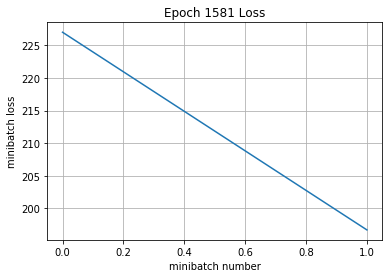

Epoch 1582, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1583, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.98
Epoch 1584, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 1585, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 1586, Overall loss = 0.0367, accuracy of 0.985 and f1 score of 0.98
Epoch 1587, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.99
Epoch 1588, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1589, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1590, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.99
Epoch 1591, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.334, accuracy of 0.928 and f1 score of 0.929


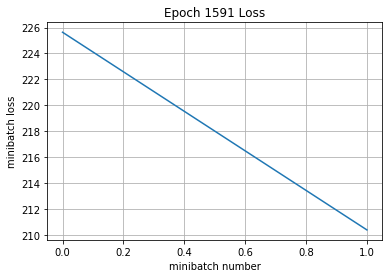

Epoch 1592, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Epoch 1593, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1594, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Epoch 1595, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 1596, Overall loss = 0.0393, accuracy of 0.986 and f1 score of 0.98
Epoch 1597, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 1598, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 1599, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 1600, Overall loss = 0.0392, accuracy of 0.986 and f1 score of 0.98
Iteration 3200: with minibatch training loss = 0.0361, accuracy of 0.99, and f1 score of 0.99
Epoch 1601, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.314, accuracy of 0.93 and f1 score of 0.935


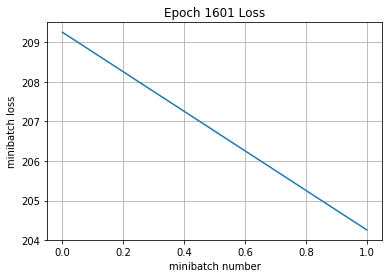

Epoch 1602, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1603, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.98
Epoch 1604, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1605, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1606, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 1607, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1608, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 1609, Overall loss = 0.0342, accuracy of 0.988 and f1 score of 0.99
Epoch 1610, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.98
Epoch 1611, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.317, accuracy of 0.932 and f1 score of 0.935


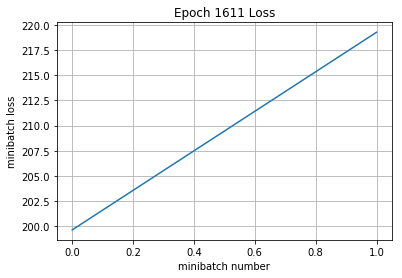

Epoch 1612, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1613, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 1614, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1615, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1616, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.99
Epoch 1617, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1618, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.99
Epoch 1619, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1620, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.99
Epoch 1621, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.331, accuracy of 0.926 and f1 score of 0.929


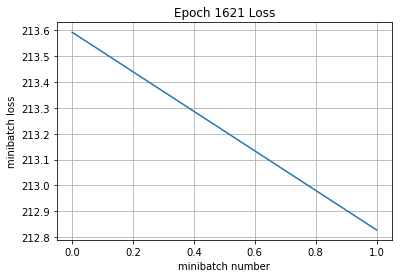

Epoch 1622, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1623, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1624, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 1625, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1626, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.99
Epoch 1627, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1628, Overall loss = 0.0405, accuracy of 0.986 and f1 score of 0.98
Epoch 1629, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1630, Overall loss = 0.0338, accuracy of 0.987 and f1 score of 0.99
Epoch 1631, Overall loss = 0.0335, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.324, accuracy of 0.928 and f1 score of 0.929


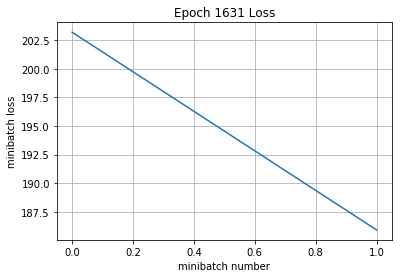

Epoch 1632, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1633, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1634, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.99
Epoch 1635, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1636, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1637, Overall loss = 0.0337, accuracy of 0.989 and f1 score of 0.99
Epoch 1638, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1639, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 1640, Overall loss = 0.0349, accuracy of 0.986 and f1 score of 0.99
Epoch 1641, Overall loss = 0.0342, accuracy of 0.989 and f1 score of 0.99
Validation loss, Overall loss = 0.322, accuracy of 0.93 and f1 score of 0.933


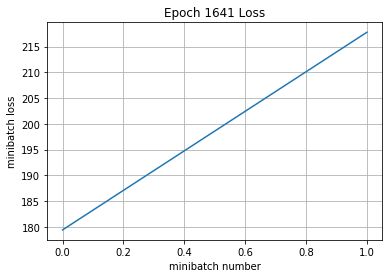

Epoch 1642, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 1643, Overall loss = 0.0335, accuracy of 0.988 and f1 score of 0.99
Epoch 1644, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1645, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1646, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.99
Epoch 1647, Overall loss = 0.0331, accuracy of 0.988 and f1 score of 0.99
Epoch 1648, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.99
Epoch 1649, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 1650, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Iteration 3300: with minibatch training loss = 0.038, accuracy of 0.99, and f1 score of 0.98
Epoch 1651, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.325, accuracy of 0.927 and f1 score of 0.93


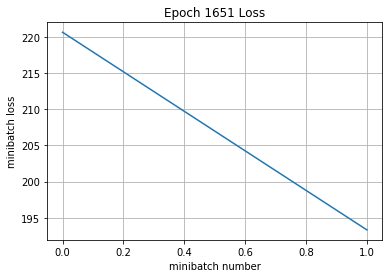

Epoch 1652, Overall loss = 0.0327, accuracy of 0.989 and f1 score of 0.99
Epoch 1653, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.99
Epoch 1654, Overall loss = 0.0383, accuracy of 0.986 and f1 score of 0.99
Epoch 1655, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.99
Epoch 1656, Overall loss = 0.0351, accuracy of 0.986 and f1 score of 0.99
Epoch 1657, Overall loss = 0.0374, accuracy of 0.985 and f1 score of 0.98
Epoch 1658, Overall loss = 0.0381, accuracy of 0.985 and f1 score of 0.98
Epoch 1659, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 1660, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.99
Epoch 1661, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.316, accuracy of 0.932 and f1 score of 0.931


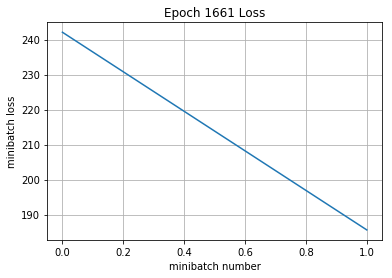

Epoch 1662, Overall loss = 0.0344, accuracy of 0.988 and f1 score of 0.99
Epoch 1663, Overall loss = 0.0385, accuracy of 0.986 and f1 score of 0.98
Epoch 1664, Overall loss = 0.034, accuracy of 0.987 and f1 score of 0.99
Epoch 1665, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.98
Epoch 1666, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.99
Epoch 1667, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.98
Epoch 1668, Overall loss = 0.0389, accuracy of 0.985 and f1 score of 0.98
Epoch 1669, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.98
Epoch 1670, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1671, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.316, accuracy of 0.929 and f1 score of 0.932


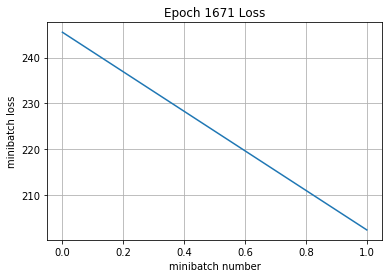

Epoch 1672, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1673, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1674, Overall loss = 0.0331, accuracy of 0.988 and f1 score of 0.99
Epoch 1675, Overall loss = 0.0362, accuracy of 0.986 and f1 score of 0.98
Epoch 1676, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 1677, Overall loss = 0.0367, accuracy of 0.988 and f1 score of 0.99
Epoch 1678, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 1679, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.98
Epoch 1680, Overall loss = 0.0337, accuracy of 0.989 and f1 score of 0.99
Epoch 1681, Overall loss = 0.0357, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.932 and f1 score of 0.933


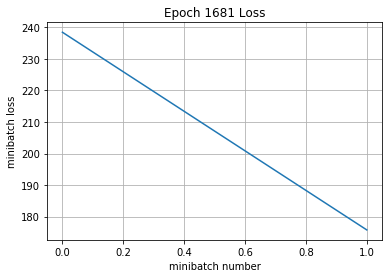

Epoch 1682, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 1683, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1684, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 1685, Overall loss = 0.0375, accuracy of 0.988 and f1 score of 0.99
Epoch 1686, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1687, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.99
Epoch 1688, Overall loss = 0.0389, accuracy of 0.985 and f1 score of 0.98
Epoch 1689, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 1690, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.98
Epoch 1691, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.325, accuracy of 0.93 and f1 score of 0.931


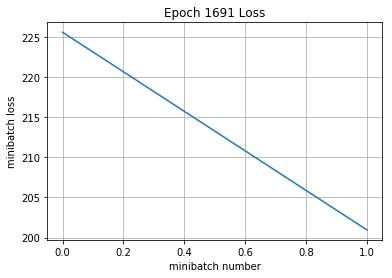

Epoch 1692, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 1693, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 1694, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1695, Overall loss = 0.0374, accuracy of 0.985 and f1 score of 0.98
Epoch 1696, Overall loss = 0.0387, accuracy of 0.988 and f1 score of 0.99
Epoch 1697, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.99
Epoch 1698, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1699, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 1700, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Iteration 3400: with minibatch training loss = 0.0355, accuracy of 0.99, and f1 score of 0.99
Epoch 1701, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.326, accuracy of 0.931 and f1 score of 0.931


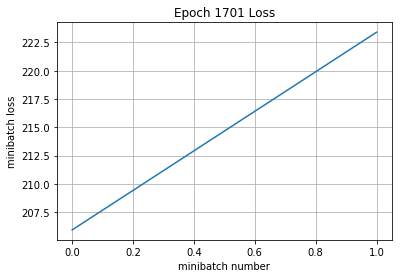

Epoch 1702, Overall loss = 0.0404, accuracy of 0.986 and f1 score of 0.98
Epoch 1703, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 1704, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1705, Overall loss = 0.0339, accuracy of 0.989 and f1 score of 0.99
Epoch 1706, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 1707, Overall loss = 0.0383, accuracy of 0.985 and f1 score of 0.98
Epoch 1708, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1709, Overall loss = 0.0367, accuracy of 0.988 and f1 score of 0.99
Epoch 1710, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.99
Epoch 1711, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.338, accuracy of 0.925 and f1 score of 0.927


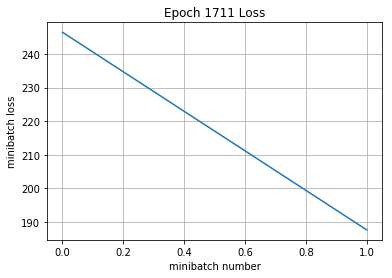

Epoch 1712, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.99
Epoch 1713, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1714, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1715, Overall loss = 0.0338, accuracy of 0.988 and f1 score of 0.99
Epoch 1716, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.99
Epoch 1717, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 1718, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.98
Epoch 1719, Overall loss = 0.0385, accuracy of 0.987 and f1 score of 0.98
Epoch 1720, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.98
Epoch 1721, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.317, accuracy of 0.931 and f1 score of 0.933


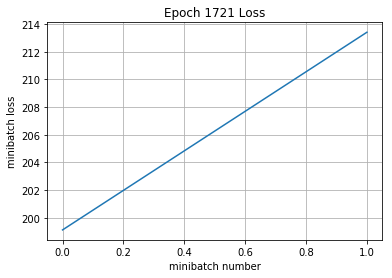

Epoch 1722, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.98
Epoch 1723, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.98
Epoch 1724, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1725, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 1726, Overall loss = 0.0337, accuracy of 0.988 and f1 score of 0.99
Epoch 1727, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1728, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.99
Epoch 1729, Overall loss = 0.0351, accuracy of 0.986 and f1 score of 0.99
Epoch 1730, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1731, Overall loss = 0.0336, accuracy of 0.989 and f1 score of 0.99
Validation loss, Overall loss = 0.314, accuracy of 0.927 and f1 score of 0.929


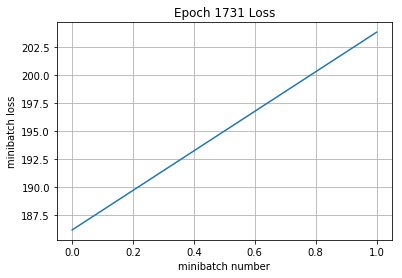

Epoch 1732, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1733, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1734, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 1735, Overall loss = 0.0387, accuracy of 0.985 and f1 score of 0.98
Epoch 1736, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1737, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.98
Epoch 1738, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 1739, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 1740, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.99
Epoch 1741, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.328, accuracy of 0.928 and f1 score of 0.93


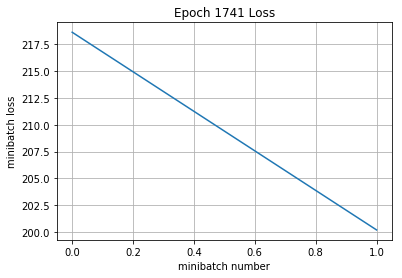

Epoch 1742, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 1743, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1744, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.98
Epoch 1745, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1746, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Epoch 1747, Overall loss = 0.0341, accuracy of 0.987 and f1 score of 0.99
Epoch 1748, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Epoch 1749, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1750, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Iteration 3500: with minibatch training loss = 0.0373, accuracy of 0.99, and f1 score of 0.98
Epoch 1751, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.313, accuracy of 0.932 and f1 score of 0.933


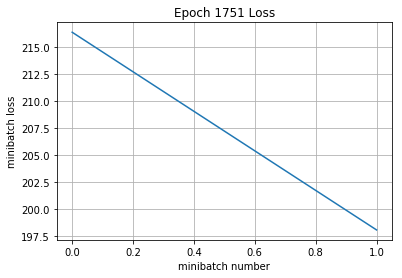

Epoch 1752, Overall loss = 0.0335, accuracy of 0.987 and f1 score of 0.99
Epoch 1753, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.98
Epoch 1754, Overall loss = 0.0399, accuracy of 0.985 and f1 score of 0.98
Epoch 1755, Overall loss = 0.0373, accuracy of 0.985 and f1 score of 0.98
Epoch 1756, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Epoch 1757, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1758, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.99
Epoch 1759, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1760, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1761, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.334, accuracy of 0.929 and f1 score of 0.931


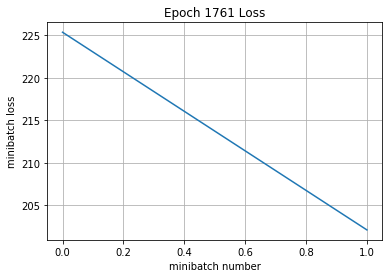

Epoch 1762, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1763, Overall loss = 0.032, accuracy of 0.988 and f1 score of 0.99
Epoch 1764, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1765, Overall loss = 0.0347, accuracy of 0.987 and f1 score of 0.98
Epoch 1766, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1767, Overall loss = 0.0333, accuracy of 0.987 and f1 score of 0.98
Epoch 1768, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 1769, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.98
Epoch 1770, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 1771, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.324, accuracy of 0.928 and f1 score of 0.93


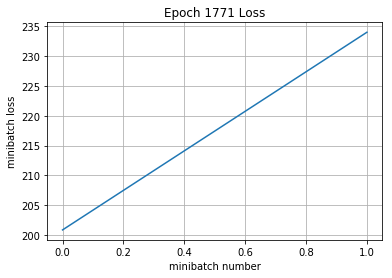

Epoch 1772, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Epoch 1773, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1774, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1775, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.99
Epoch 1776, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1777, Overall loss = 0.034, accuracy of 0.988 and f1 score of 0.99
Epoch 1778, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.98
Epoch 1779, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.99
Epoch 1780, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.98
Epoch 1781, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.324, accuracy of 0.928 and f1 score of 0.931


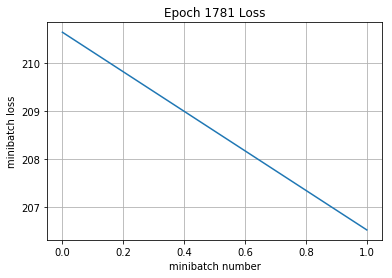

Epoch 1782, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.98
Epoch 1783, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 1784, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 1785, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 1786, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.98
Epoch 1787, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1788, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.98
Epoch 1789, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1790, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Epoch 1791, Overall loss = 0.0338, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.928 and f1 score of 0.933


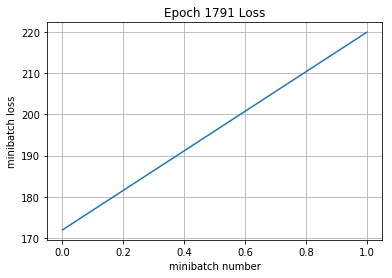

Epoch 1792, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1793, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1794, Overall loss = 0.0383, accuracy of 0.987 and f1 score of 0.99
Epoch 1795, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.98
Epoch 1796, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 1797, Overall loss = 0.038, accuracy of 0.985 and f1 score of 0.98
Epoch 1798, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 1799, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1800, Overall loss = 0.0375, accuracy of 0.985 and f1 score of 0.98
Iteration 3600: with minibatch training loss = 0.0382, accuracy of 0.99, and f1 score of 0.98
Epoch 1801, Overall loss = 0.0401, accuracy of 0.985 and f1 score of 0.98
Validation loss, Overall loss = 0.323, accuracy of 0.928 and f1 score of 0.932


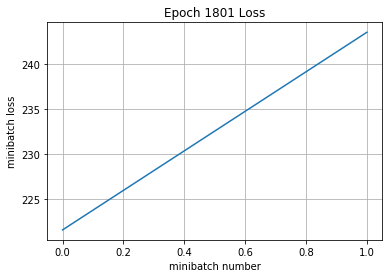

Epoch 1802, Overall loss = 0.0344, accuracy of 0.987 and f1 score of 0.99
Epoch 1803, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 1804, Overall loss = 0.0331, accuracy of 0.987 and f1 score of 0.99
Epoch 1805, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1806, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 1807, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 1808, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 1809, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 1810, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 1811, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.334, accuracy of 0.927 and f1 score of 0.928


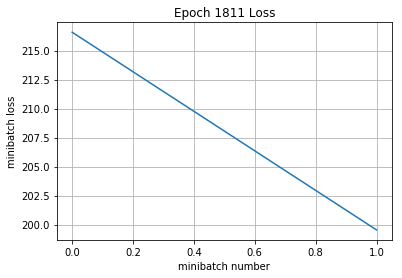

Epoch 1812, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1813, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.98
Epoch 1814, Overall loss = 0.0328, accuracy of 0.989 and f1 score of 0.99
Epoch 1815, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 1816, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1817, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.99
Epoch 1818, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1819, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 1820, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1821, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.316, accuracy of 0.929 and f1 score of 0.932


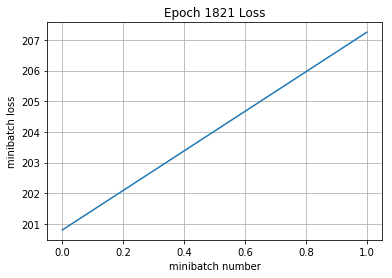

Epoch 1822, Overall loss = 0.0333, accuracy of 0.988 and f1 score of 0.99
Epoch 1823, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1824, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 1825, Overall loss = 0.0332, accuracy of 0.988 and f1 score of 0.99
Epoch 1826, Overall loss = 0.0333, accuracy of 0.987 and f1 score of 0.99
Epoch 1827, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.99
Epoch 1828, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 1829, Overall loss = 0.0348, accuracy of 0.989 and f1 score of 0.99
Epoch 1830, Overall loss = 0.0357, accuracy of 0.986 and f1 score of 0.98
Epoch 1831, Overall loss = 0.0342, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.315, accuracy of 0.931 and f1 score of 0.934


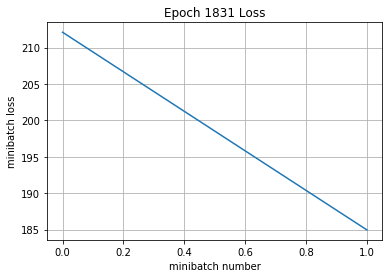

Epoch 1832, Overall loss = 0.0347, accuracy of 0.987 and f1 score of 0.99
Epoch 1833, Overall loss = 0.0361, accuracy of 0.988 and f1 score of 0.99
Epoch 1834, Overall loss = 0.0324, accuracy of 0.989 and f1 score of 0.99
Epoch 1835, Overall loss = 0.0337, accuracy of 0.988 and f1 score of 0.99
Epoch 1836, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 1837, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1838, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 1839, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 1840, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 1841, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.932 and f1 score of 0.933


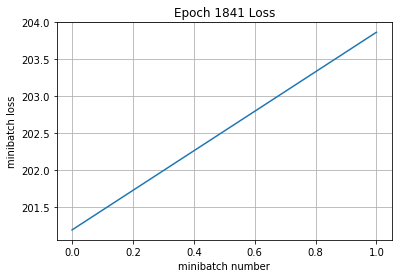

Epoch 1842, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 1843, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.99
Epoch 1844, Overall loss = 0.0338, accuracy of 0.988 and f1 score of 0.99
Epoch 1845, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 1846, Overall loss = 0.0335, accuracy of 0.988 and f1 score of 0.99
Epoch 1847, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Epoch 1848, Overall loss = 0.0359, accuracy of 0.986 and f1 score of 0.98
Epoch 1849, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Epoch 1850, Overall loss = 0.038, accuracy of 0.985 and f1 score of 0.98
Iteration 3700: with minibatch training loss = 0.0343, accuracy of 0.99, and f1 score of 0.99
Epoch 1851, Overall loss = 0.0362, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.311, accuracy of 0.931 and f1 score of 0.934


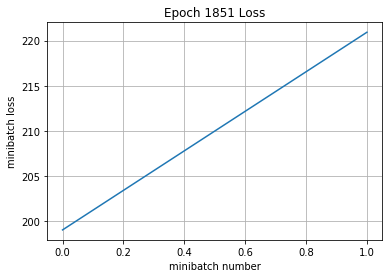

Epoch 1852, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1853, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1854, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.98
Epoch 1855, Overall loss = 0.0358, accuracy of 0.986 and f1 score of 0.98
Epoch 1856, Overall loss = 0.0332, accuracy of 0.989 and f1 score of 0.99
Epoch 1857, Overall loss = 0.0347, accuracy of 0.989 and f1 score of 0.99
Epoch 1858, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 1859, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 1860, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Epoch 1861, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.322, accuracy of 0.928 and f1 score of 0.93


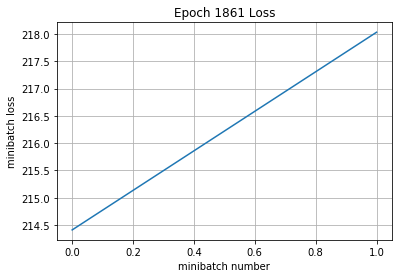

Epoch 1862, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.98
Epoch 1863, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.98
Epoch 1864, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.99
Epoch 1865, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 1866, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 1867, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1868, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Epoch 1869, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1870, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 1871, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.327, accuracy of 0.928 and f1 score of 0.928


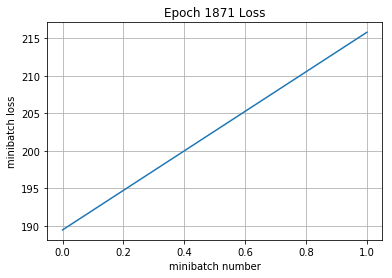

Epoch 1872, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 1873, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1874, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1875, Overall loss = 0.0371, accuracy of 0.988 and f1 score of 0.99
Epoch 1876, Overall loss = 0.034, accuracy of 0.989 and f1 score of 0.99
Epoch 1877, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 1878, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.98
Epoch 1879, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 1880, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.98
Epoch 1881, Overall loss = 0.0362, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.331, accuracy of 0.929 and f1 score of 0.932


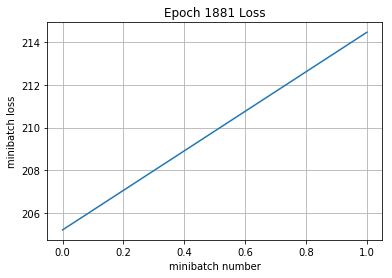

Epoch 1882, Overall loss = 0.0386, accuracy of 0.985 and f1 score of 0.98
Epoch 1883, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.98
Epoch 1884, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.98
Epoch 1885, Overall loss = 0.0324, accuracy of 0.988 and f1 score of 0.99
Epoch 1886, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 1887, Overall loss = 0.0345, accuracy of 0.989 and f1 score of 0.99
Epoch 1888, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 1889, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 1890, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 1891, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.329, accuracy of 0.93 and f1 score of 0.93


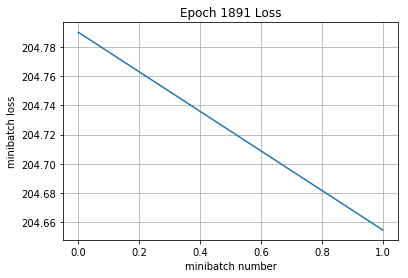

Epoch 1892, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.98
Epoch 1893, Overall loss = 0.0356, accuracy of 0.988 and f1 score of 0.99
Epoch 1894, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1895, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.98
Epoch 1896, Overall loss = 0.0346, accuracy of 0.986 and f1 score of 0.98
Epoch 1897, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.99
Epoch 1898, Overall loss = 0.0358, accuracy of 0.988 and f1 score of 0.99
Epoch 1899, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 1900, Overall loss = 0.0334, accuracy of 0.989 and f1 score of 0.99
Iteration 3800: with minibatch training loss = 0.0398, accuracy of 0.99, and f1 score of 0.98
Epoch 1901, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.318, accuracy of 0.929 and f1 score of 0.93


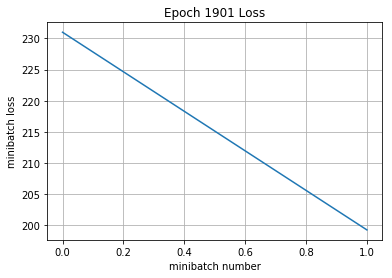

Epoch 1902, Overall loss = 0.0352, accuracy of 0.986 and f1 score of 0.99
Epoch 1903, Overall loss = 0.0351, accuracy of 0.986 and f1 score of 0.99
Epoch 1904, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 1905, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1906, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.99
Epoch 1907, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.98
Epoch 1908, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1909, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.98
Epoch 1910, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 1911, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.93 and f1 score of 0.932


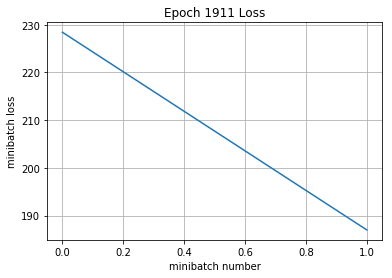

Epoch 1912, Overall loss = 0.036, accuracy of 0.986 and f1 score of 0.99
Epoch 1913, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.98
Epoch 1914, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1915, Overall loss = 0.0384, accuracy of 0.985 and f1 score of 0.98
Epoch 1916, Overall loss = 0.0351, accuracy of 0.987 and f1 score of 0.99
Epoch 1917, Overall loss = 0.0373, accuracy of 0.987 and f1 score of 0.99
Epoch 1918, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 1919, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.98
Epoch 1920, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 1921, Overall loss = 0.0331, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.317, accuracy of 0.931 and f1 score of 0.935


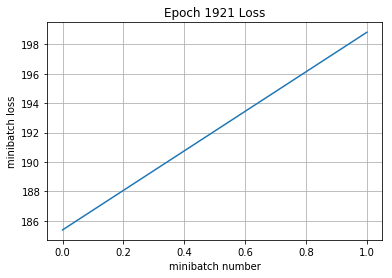

Epoch 1922, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.98
Epoch 1923, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 1924, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.98
Epoch 1925, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Epoch 1926, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.98
Epoch 1927, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 1928, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.99
Epoch 1929, Overall loss = 0.0338, accuracy of 0.988 and f1 score of 0.99
Epoch 1930, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1931, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.318, accuracy of 0.93 and f1 score of 0.93


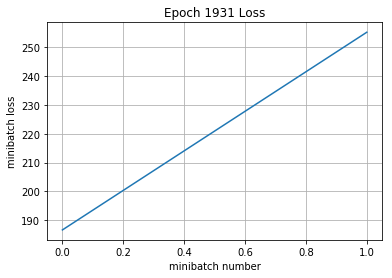

Epoch 1932, Overall loss = 0.0331, accuracy of 0.989 and f1 score of 0.99
Epoch 1933, Overall loss = 0.0379, accuracy of 0.987 and f1 score of 0.99
Epoch 1934, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 1935, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.98
Epoch 1936, Overall loss = 0.0369, accuracy of 0.986 and f1 score of 0.98
Epoch 1937, Overall loss = 0.0327, accuracy of 0.989 and f1 score of 0.99
Epoch 1938, Overall loss = 0.039, accuracy of 0.986 and f1 score of 0.98
Epoch 1939, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Epoch 1940, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 1941, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.316, accuracy of 0.933 and f1 score of 0.935


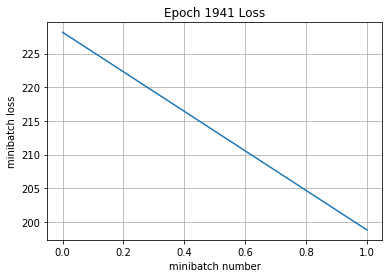

Epoch 1942, Overall loss = 0.0357, accuracy of 0.986 and f1 score of 0.98
Epoch 1943, Overall loss = 0.0363, accuracy of 0.986 and f1 score of 0.98
Epoch 1944, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1945, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.98
Epoch 1946, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Epoch 1947, Overall loss = 0.0341, accuracy of 0.987 and f1 score of 0.99
Epoch 1948, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 1949, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 1950, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Iteration 3900: with minibatch training loss = 0.0357, accuracy of 0.99, and f1 score of 0.99
Epoch 1951, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.319, accuracy of 0.928 and f1 score of 0.93


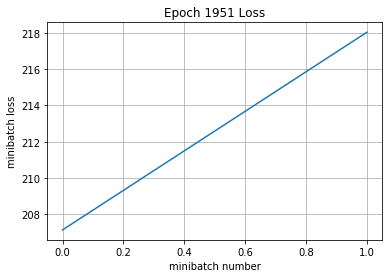

Epoch 1952, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1953, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 1954, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 1955, Overall loss = 0.0361, accuracy of 0.986 and f1 score of 0.99
Epoch 1956, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Epoch 1957, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1958, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.98
Epoch 1959, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1960, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.99
Epoch 1961, Overall loss = 0.0377, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.325, accuracy of 0.929 and f1 score of 0.931


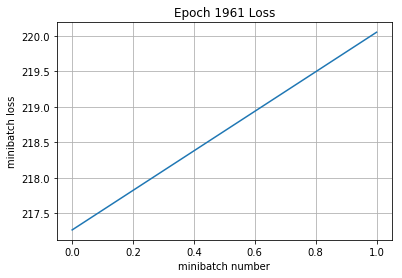

Epoch 1962, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 1963, Overall loss = 0.0335, accuracy of 0.989 and f1 score of 0.99
Epoch 1964, Overall loss = 0.0384, accuracy of 0.987 and f1 score of 0.99
Epoch 1965, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 1966, Overall loss = 0.0368, accuracy of 0.988 and f1 score of 0.99
Epoch 1967, Overall loss = 0.0378, accuracy of 0.986 and f1 score of 0.99
Epoch 1968, Overall loss = 0.0343, accuracy of 0.987 and f1 score of 0.99
Epoch 1969, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1970, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 1971, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.322, accuracy of 0.928 and f1 score of 0.929


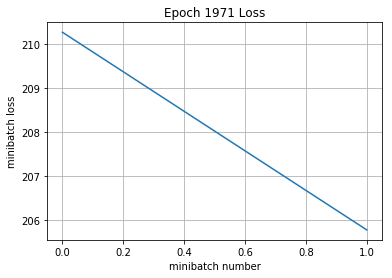

Epoch 1972, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.98
Epoch 1973, Overall loss = 0.0402, accuracy of 0.985 and f1 score of 0.98
Epoch 1974, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 1975, Overall loss = 0.0337, accuracy of 0.988 and f1 score of 0.99
Epoch 1976, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Epoch 1977, Overall loss = 0.0356, accuracy of 0.987 and f1 score of 0.99
Epoch 1978, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 1979, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.99
Epoch 1980, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 1981, Overall loss = 0.0373, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.316, accuracy of 0.93 and f1 score of 0.936


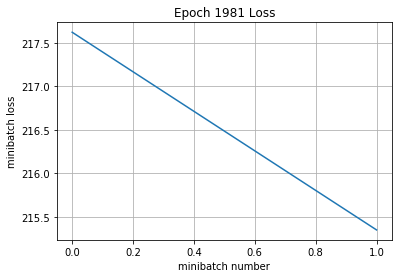

Epoch 1982, Overall loss = 0.0346, accuracy of 0.989 and f1 score of 0.99
Epoch 1983, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 1984, Overall loss = 0.0367, accuracy of 0.987 and f1 score of 0.99
Epoch 1985, Overall loss = 0.0364, accuracy of 0.988 and f1 score of 0.99
Epoch 1986, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 1987, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.98
Epoch 1988, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.98
Epoch 1989, Overall loss = 0.0386, accuracy of 0.987 and f1 score of 0.99
Epoch 1990, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Epoch 1991, Overall loss = 0.0355, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.31, accuracy of 0.932 and f1 score of 0.934


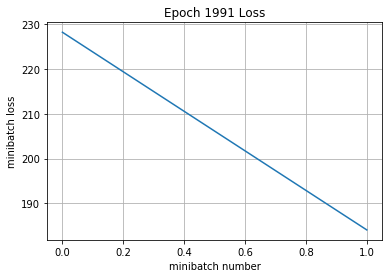

Epoch 1992, Overall loss = 0.0356, accuracy of 0.986 and f1 score of 0.98
Epoch 1993, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 1994, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 1995, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.98
Epoch 1996, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 1997, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 1998, Overall loss = 0.0365, accuracy of 0.985 and f1 score of 0.98
Epoch 1999, Overall loss = 0.0361, accuracy of 0.985 and f1 score of 0.98
Epoch 2000, Overall loss = 0.0335, accuracy of 0.988 and f1 score of 0.99
Iteration 4000: with minibatch training loss = 0.0329, accuracy of 0.99, and f1 score of 0.99
Epoch 2001, Overall loss = 0.0335, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.32, accuracy of 0.932 and f1 score of 0.934


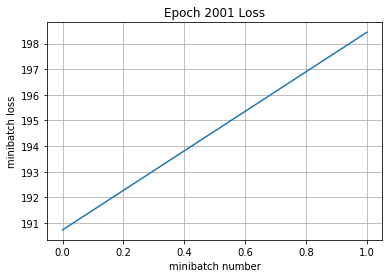

Epoch 2002, Overall loss = 0.036, accuracy of 0.988 and f1 score of 0.99
Epoch 2003, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.98
Epoch 2004, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 2005, Overall loss = 0.0361, accuracy of 0.988 and f1 score of 0.99
Epoch 2006, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 2007, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 2008, Overall loss = 0.0344, accuracy of 0.988 and f1 score of 0.99
Epoch 2009, Overall loss = 0.0355, accuracy of 0.988 and f1 score of 0.99
Epoch 2010, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 2011, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.928 and f1 score of 0.931


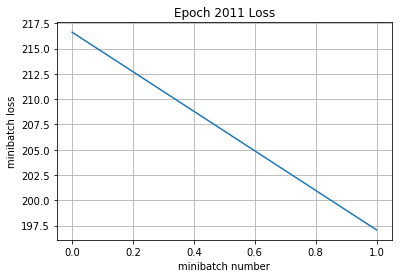

Epoch 2012, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 2013, Overall loss = 0.0336, accuracy of 0.988 and f1 score of 0.99
Epoch 2014, Overall loss = 0.0361, accuracy of 0.987 and f1 score of 0.98
Epoch 2015, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 2016, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 2017, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.98
Epoch 2018, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 2019, Overall loss = 0.0366, accuracy of 0.986 and f1 score of 0.98
Epoch 2020, Overall loss = 0.0333, accuracy of 0.988 and f1 score of 0.99
Epoch 2021, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.323, accuracy of 0.929 and f1 score of 0.93


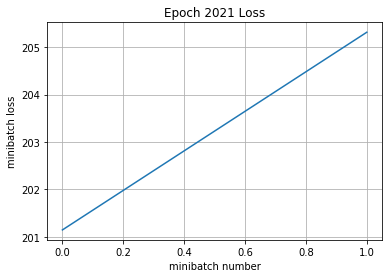

Epoch 2022, Overall loss = 0.034, accuracy of 0.988 and f1 score of 0.99
Epoch 2023, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 2024, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 2025, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 2026, Overall loss = 0.0372, accuracy of 0.986 and f1 score of 0.98
Epoch 2027, Overall loss = 0.0342, accuracy of 0.988 and f1 score of 0.99
Epoch 2028, Overall loss = 0.0386, accuracy of 0.986 and f1 score of 0.98
Epoch 2029, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 2030, Overall loss = 0.0371, accuracy of 0.986 and f1 score of 0.99
Epoch 2031, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.325, accuracy of 0.929 and f1 score of 0.935


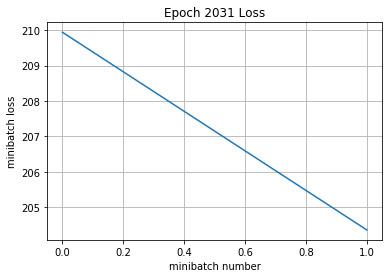

Epoch 2032, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 2033, Overall loss = 0.0376, accuracy of 0.986 and f1 score of 0.98
Epoch 2034, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.99
Epoch 2035, Overall loss = 0.034, accuracy of 0.989 and f1 score of 0.99
Epoch 2036, Overall loss = 0.0331, accuracy of 0.988 and f1 score of 0.99
Epoch 2037, Overall loss = 0.0365, accuracy of 0.988 and f1 score of 0.99
Epoch 2038, Overall loss = 0.0389, accuracy of 0.986 and f1 score of 0.98
Epoch 2039, Overall loss = 0.0368, accuracy of 0.988 and f1 score of 0.99
Epoch 2040, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 2041, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.33, accuracy of 0.928 and f1 score of 0.931


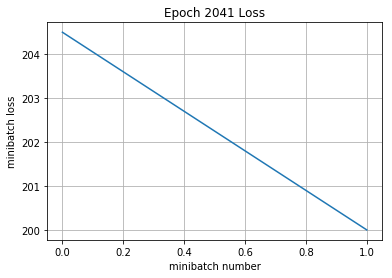

Epoch 2042, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 2043, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99
Epoch 2044, Overall loss = 0.0371, accuracy of 0.987 and f1 score of 0.99
Epoch 2045, Overall loss = 0.0326, accuracy of 0.989 and f1 score of 0.99
Epoch 2046, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 2047, Overall loss = 0.034, accuracy of 0.988 and f1 score of 0.99
Epoch 2048, Overall loss = 0.0341, accuracy of 0.988 and f1 score of 0.99
Epoch 2049, Overall loss = 0.0381, accuracy of 0.987 and f1 score of 0.99
Epoch 2050, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Iteration 4100: with minibatch training loss = 0.0386, accuracy of 0.99, and f1 score of 0.98
Epoch 2051, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.325, accuracy of 0.931 and f1 score of 0.93


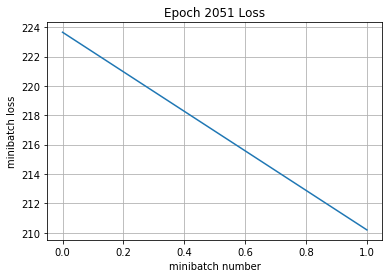

Epoch 2052, Overall loss = 0.0335, accuracy of 0.987 and f1 score of 0.99
Epoch 2053, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 2054, Overall loss = 0.0362, accuracy of 0.988 and f1 score of 0.99
Epoch 2055, Overall loss = 0.035, accuracy of 0.987 and f1 score of 0.99
Epoch 2056, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 2057, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 2058, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 2059, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.98
Epoch 2060, Overall loss = 0.0362, accuracy of 0.986 and f1 score of 0.98
Epoch 2061, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.327, accuracy of 0.93 and f1 score of 0.934


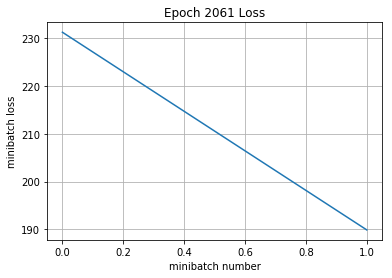

Epoch 2062, Overall loss = 0.0373, accuracy of 0.986 and f1 score of 0.98
Epoch 2063, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 2064, Overall loss = 0.0313, accuracy of 0.99 and f1 score of 0.99
Epoch 2065, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 2066, Overall loss = 0.036, accuracy of 0.987 and f1 score of 0.99
Epoch 2067, Overall loss = 0.0351, accuracy of 0.988 and f1 score of 0.99
Epoch 2068, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 2069, Overall loss = 0.0324, accuracy of 0.989 and f1 score of 0.99
Epoch 2070, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 2071, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.31, accuracy of 0.931 and f1 score of 0.932


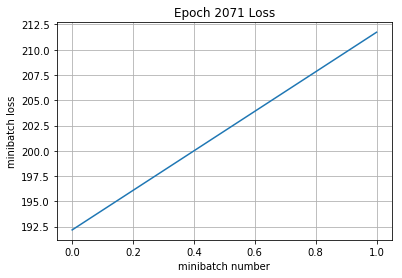

Epoch 2072, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 2073, Overall loss = 0.0367, accuracy of 0.986 and f1 score of 0.98
Epoch 2074, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 2075, Overall loss = 0.0359, accuracy of 0.987 and f1 score of 0.99
Epoch 2076, Overall loss = 0.0338, accuracy of 0.987 and f1 score of 0.99
Epoch 2077, Overall loss = 0.0337, accuracy of 0.988 and f1 score of 0.99
Epoch 2078, Overall loss = 0.0368, accuracy of 0.986 and f1 score of 0.99
Epoch 2079, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.98
Epoch 2080, Overall loss = 0.0368, accuracy of 0.987 and f1 score of 0.98
Epoch 2081, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.98
Validation loss, Overall loss = 0.322, accuracy of 0.927 and f1 score of 0.926


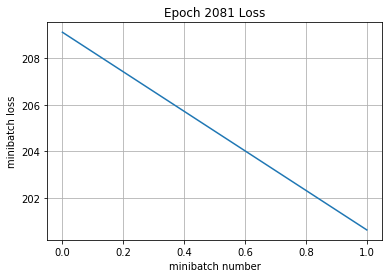

Epoch 2082, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 2083, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 2084, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 2085, Overall loss = 0.0374, accuracy of 0.987 and f1 score of 0.99
Epoch 2086, Overall loss = 0.0364, accuracy of 0.986 and f1 score of 0.98
Epoch 2087, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 2088, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 2089, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Epoch 2090, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.99
Epoch 2091, Overall loss = 0.0345, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.326, accuracy of 0.931 and f1 score of 0.933


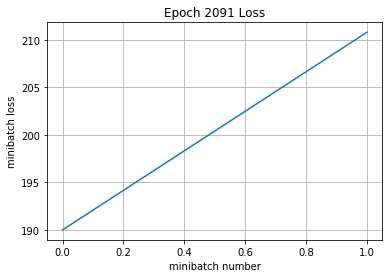

Epoch 2092, Overall loss = 0.0355, accuracy of 0.987 and f1 score of 0.99
Epoch 2093, Overall loss = 0.033, accuracy of 0.99 and f1 score of 0.99
Epoch 2094, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 2095, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 2096, Overall loss = 0.033, accuracy of 0.989 and f1 score of 0.99
Epoch 2097, Overall loss = 0.0387, accuracy of 0.987 and f1 score of 0.98
Epoch 2098, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 2099, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 2100, Overall loss = 0.0342, accuracy of 0.987 and f1 score of 0.99
Iteration 4200: with minibatch training loss = 0.0362, accuracy of 0.99, and f1 score of 0.99
Epoch 2101, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.324, accuracy of 0.929 and f1 score of 0.927


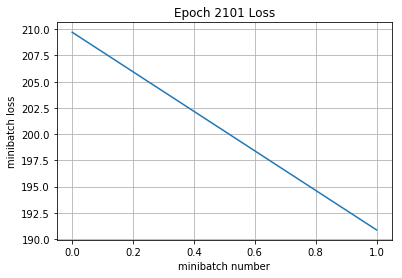

Epoch 2102, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 2103, Overall loss = 0.0356, accuracy of 0.986 and f1 score of 0.98
Epoch 2104, Overall loss = 0.0382, accuracy of 0.987 and f1 score of 0.99
Epoch 2105, Overall loss = 0.0391, accuracy of 0.986 and f1 score of 0.98
Epoch 2106, Overall loss = 0.0369, accuracy of 0.987 and f1 score of 0.99
Epoch 2107, Overall loss = 0.0336, accuracy of 0.987 and f1 score of 0.99
Epoch 2108, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.98
Epoch 2109, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.98
Epoch 2110, Overall loss = 0.0336, accuracy of 0.988 and f1 score of 0.99
Epoch 2111, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.322, accuracy of 0.933 and f1 score of 0.936


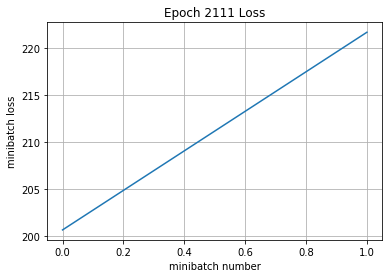

Epoch 2112, Overall loss = 0.0327, accuracy of 0.989 and f1 score of 0.99
Epoch 2113, Overall loss = 0.036, accuracy of 0.986 and f1 score of 0.99
Epoch 2114, Overall loss = 0.0362, accuracy of 0.988 and f1 score of 0.99
Epoch 2115, Overall loss = 0.0347, accuracy of 0.987 and f1 score of 0.98
Epoch 2116, Overall loss = 0.0324, accuracy of 0.988 and f1 score of 0.99
Epoch 2117, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 2118, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 2119, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.99
Epoch 2120, Overall loss = 0.0372, accuracy of 0.987 and f1 score of 0.98
Epoch 2121, Overall loss = 0.038, accuracy of 0.986 and f1 score of 0.98
Validation loss, Overall loss = 0.313, accuracy of 0.933 and f1 score of 0.936


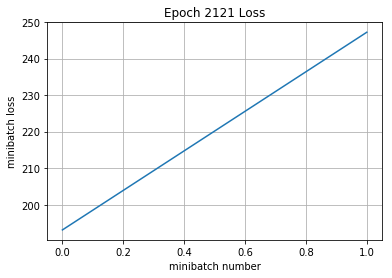

Epoch 2122, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 2123, Overall loss = 0.0366, accuracy of 0.987 and f1 score of 0.99
Epoch 2124, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.99
Epoch 2125, Overall loss = 0.0343, accuracy of 0.988 and f1 score of 0.99
Epoch 2126, Overall loss = 0.0355, accuracy of 0.986 and f1 score of 0.99
Epoch 2127, Overall loss = 0.033, accuracy of 0.989 and f1 score of 0.99
Epoch 2128, Overall loss = 0.0338, accuracy of 0.988 and f1 score of 0.99
Epoch 2129, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 2130, Overall loss = 0.0382, accuracy of 0.986 and f1 score of 0.98
Epoch 2131, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.325, accuracy of 0.928 and f1 score of 0.93


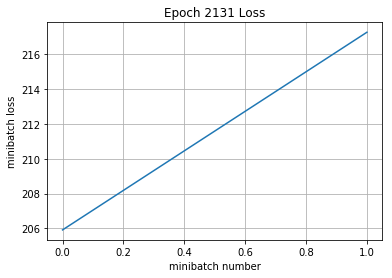

Epoch 2132, Overall loss = 0.0375, accuracy of 0.986 and f1 score of 0.98
Epoch 2133, Overall loss = 0.0358, accuracy of 0.987 and f1 score of 0.99
Epoch 2134, Overall loss = 0.0376, accuracy of 0.985 and f1 score of 0.98
Epoch 2135, Overall loss = 0.0338, accuracy of 0.987 and f1 score of 0.99
Epoch 2136, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 2137, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 2138, Overall loss = 0.037, accuracy of 0.987 and f1 score of 0.99
Epoch 2139, Overall loss = 0.0374, accuracy of 0.986 and f1 score of 0.98
Epoch 2140, Overall loss = 0.0357, accuracy of 0.988 and f1 score of 0.99
Epoch 2141, Overall loss = 0.0379, accuracy of 0.988 and f1 score of 0.99
Validation loss, Overall loss = 0.332, accuracy of 0.93 and f1 score of 0.935


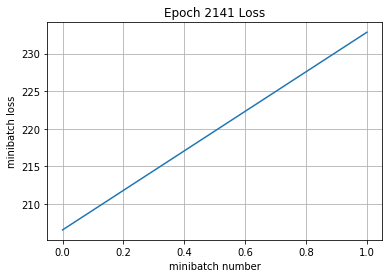

Epoch 2142, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 2143, Overall loss = 0.0338, accuracy of 0.987 and f1 score of 0.99
Epoch 2144, Overall loss = 0.0359, accuracy of 0.988 and f1 score of 0.99
Epoch 2145, Overall loss = 0.0381, accuracy of 0.986 and f1 score of 0.98
Epoch 2146, Overall loss = 0.0331, accuracy of 0.988 and f1 score of 0.99
Epoch 2147, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 2148, Overall loss = 0.0348, accuracy of 0.987 and f1 score of 0.99
Epoch 2149, Overall loss = 0.0363, accuracy of 0.987 and f1 score of 0.98
Epoch 2150, Overall loss = 0.0341, accuracy of 0.987 and f1 score of 0.99
Iteration 4300: with minibatch training loss = 0.0331, accuracy of 0.99, and f1 score of 0.99
Epoch 2151, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.328, accuracy of 0.93 and f1 score of 0.931


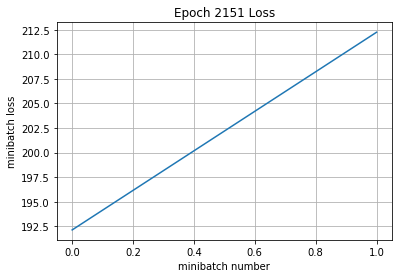

Epoch 2152, Overall loss = 0.0333, accuracy of 0.989 and f1 score of 0.99
Epoch 2153, Overall loss = 0.0353, accuracy of 0.989 and f1 score of 0.99
Epoch 2154, Overall loss = 0.0345, accuracy of 0.988 and f1 score of 0.99
Epoch 2155, Overall loss = 0.0378, accuracy of 0.987 and f1 score of 0.98
Epoch 2156, Overall loss = 0.0377, accuracy of 0.987 and f1 score of 0.99
Epoch 2157, Overall loss = 0.0365, accuracy of 0.987 and f1 score of 0.99
Epoch 2158, Overall loss = 0.037, accuracy of 0.986 and f1 score of 0.98
Epoch 2159, Overall loss = 0.0354, accuracy of 0.986 and f1 score of 0.99
Epoch 2160, Overall loss = 0.0354, accuracy of 0.988 and f1 score of 0.99
Epoch 2161, Overall loss = 0.0387, accuracy of 0.986 and f1 score of 0.99
Validation loss, Overall loss = 0.312, accuracy of 0.934 and f1 score of 0.935


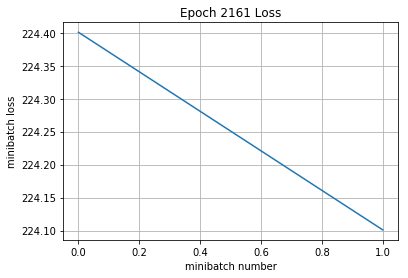

Epoch 2162, Overall loss = 0.0316, accuracy of 0.988 and f1 score of 0.99
Epoch 2163, Overall loss = 0.0357, accuracy of 0.987 and f1 score of 0.99
Epoch 2164, Overall loss = 0.0358, accuracy of 0.986 and f1 score of 0.98
Epoch 2165, Overall loss = 0.0339, accuracy of 0.988 and f1 score of 0.99
Epoch 2166, Overall loss = 0.0349, accuracy of 0.988 and f1 score of 0.99
Epoch 2167, Overall loss = 0.0375, accuracy of 0.987 and f1 score of 0.98
Epoch 2168, Overall loss = 0.0363, accuracy of 0.988 and f1 score of 0.99
Epoch 2169, Overall loss = 0.0398, accuracy of 0.986 and f1 score of 0.98
Epoch 2170, Overall loss = 0.0349, accuracy of 0.987 and f1 score of 0.99
Epoch 2171, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.325, accuracy of 0.931 and f1 score of 0.932


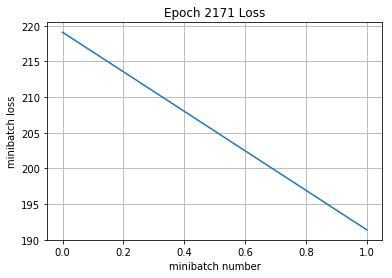

Epoch 2172, Overall loss = 0.0346, accuracy of 0.988 and f1 score of 0.99
Epoch 2173, Overall loss = 0.0348, accuracy of 0.988 and f1 score of 0.99
Epoch 2174, Overall loss = 0.0352, accuracy of 0.987 and f1 score of 0.99
Epoch 2175, Overall loss = 0.0347, accuracy of 0.988 and f1 score of 0.99
Epoch 2176, Overall loss = 0.0353, accuracy of 0.988 and f1 score of 0.99
Epoch 2177, Overall loss = 0.0353, accuracy of 0.987 and f1 score of 0.98
Epoch 2178, Overall loss = 0.0358, accuracy of 0.986 and f1 score of 0.98
Epoch 2179, Overall loss = 0.0364, accuracy of 0.987 and f1 score of 0.99
Epoch 2180, Overall loss = 0.0376, accuracy of 0.987 and f1 score of 0.98
Epoch 2181, Overall loss = 0.0362, accuracy of 0.987 and f1 score of 0.99
Validation loss, Overall loss = 0.33, accuracy of 0.931 and f1 score of 0.932


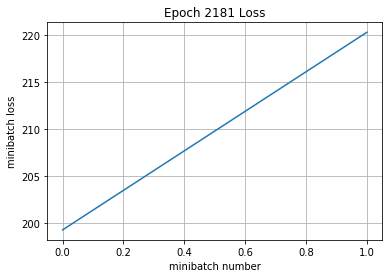

Epoch 2182, Overall loss = 0.0379, accuracy of 0.986 and f1 score of 0.98
Epoch 2183, Overall loss = 0.034, accuracy of 0.988 and f1 score of 0.99
Epoch 2184, Overall loss = 0.0395, accuracy of 0.986 and f1 score of 0.98
Epoch 2185, Overall loss = 0.035, accuracy of 0.988 and f1 score of 0.99
Epoch 2186, Overall loss = 0.033, accuracy of 0.988 and f1 score of 0.99
Epoch 2187, Overall loss = 0.0362, accuracy of 0.988 and f1 score of 0.99
Epoch 2188, Overall loss = 0.0352, accuracy of 0.988 and f1 score of 0.99
Epoch 2189, Overall loss = 0.0354, accuracy of 0.987 and f1 score of 0.98
Epoch 2190, Overall loss = 0.0359, accuracy of 0.986 and f1 score of 0.99
Epoch 2191, Overall loss = 0.0316, accuracy of 0.989 and f1 score of 0.99
Validation loss, Overall loss = 0.321, accuracy of 0.932 and f1 score of 0.933


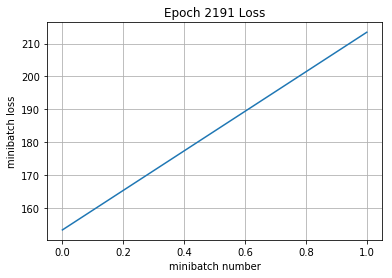

Epoch 2192, Overall loss = 0.0346, accuracy of 0.987 and f1 score of 0.99


In [ ]:
# properties
# General
# TODO : declare additional properties
# not fixed (change or add property as you like)
batch_size = 5800
epoch_num = 10000
print_every = 100

# fixed
# True if you want to train, False if you already trained your model
# TODO : IMPORTANT !!! Please change it to False when you submit your code
is_train_mode = True
train_validation = True
validation = True
# TODO : IMPORTANT !!! Please specify the path where your best model is saved
# example : checkpoint/run-0925-0348
checkpoint_path = 'checkpoint/concat_1024_mix_18_elu'

# X, y, mean_loss,correct_prediction,train_step, accuracy = my_model(lr = 2e-4, rl = 1e-4,  is_training= is_train_mode)
#load data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint_path)			
    if is_train_mode:
        variables = [mean_loss,correct_prediction, y_out, train_step]
        iter_cnt = 0
        best_f1 = 0
        best_loss = 100
        for e in range(epoch_num):                   
            train_indicies = np.arange(Xd.shape[0])
            np.random.shuffle(train_indicies)
            correct = 0
            losses = []
            f1_scores = []
            for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                start_idx = (i*batch_size)%Xd.shape[0]
                idx = train_indicies[start_idx:start_idx+batch_size]
                feed_dict = {X: Xd[idx,:],
                             y: yd[idx] }
                actual_batch_size = yd[idx].shape[0]
                loss, corr, y_outs, _ = sess.run(variables,feed_dict=feed_dict)
                losses.append(loss*actual_batch_size)
                correct += np.sum(corr)
                f1_score = calculate_average_F1_score(from_eight(onehot(y_outs)), from_eight(yd[idx]))
                f1_scores.append(f1_score*actual_batch_size)
                if is_train_mode and (iter_cnt % print_every) == 0:
                    print("Iteration {0}: with minibatch training loss = {1:.3g}, accuracy of {2:.2g}, and f1 score of {3:.2g}"\
                          .format(iter_cnt,loss,np.sum(corr)/actual_batch_size, f1_score))
                iter_cnt += 1
            total_correct = correct/Xd.shape[0]
            total_loss = np.sum(losses)/Xd.shape[0]
            total_f1 = np.sum(f1_scores)/Xd.shape[0]
            print("Epoch {2}, Overall loss = {0:.3g}, accuracy of {1:.3g} and f1 score of {3:.2g}"\
              .format(total_loss,total_correct,e+1, total_f1))
            if (e % 10 == 0) and  train_validation:
                train_losses.append(total_loss)
                correct_val = 0
                losses_val = []
                f1s_val = []
                val_indicies = np.arange(Xd_val.shape[0])
                for j in range(int(math.ceil(Xd_val.shape[0]/batch_size))):
                    start_idx = (j*batch_size)%Xd_val.shape[0]
                    idx = val_indicies[start_idx:start_idx+batch_size]
                    feed_dict_val = {X: Xd_val[idx, :],
                                 y: yd_val[idx] }
                    actual_batch_size = yd_val[idx].shape[0]
                    val_loss, val_corr, y_out_val = sess.run([mean_loss, correct_prediction, y_out] ,feed_dict=feed_dict_val)
                    losses_val.append(val_loss*actual_batch_size)
                    correct_val += np.sum(val_corr)
                    f1_score_val = calculate_average_F1_score(from_eight(onehot(y_out_val)), from_eight(yd_val[idx]))
                    f1s_val.append(f1_score_val*actual_batch_size)
                total_val_loss = np.sum(losses_val)/Xd_val.shape[0]
                total_val_correct = correct_val/Xd_val.shape[0]
                val_losses.append(total_val_loss)
                val_f1 = np.sum(f1s_val)/Xd_val.shape[0]
                print("Validation loss, Overall loss = {0:.3g}, accuracy of {1:.3g} and f1 score of {2:.3g}".format(total_val_loss, total_val_correct, val_f1))        
                plt.plot(losses)
                plt.grid(True)
                plt.title('Epoch {} Loss'.format(e+1))
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch loss')
                plt.show()
                if total_val_loss < best_loss:
                    best_loss = total_val_loss
             #         output_dir = checkpoint_path + '/run-%02d%02d-%02d%02d' % tuple(localtime(time()))[1:5]
                    output_dir = checkpoint_path
                    if not gfile.Exists(output_dir):
                        gfile.MakeDirs(output_dir)
                    saver.save(sess, output_dir)
                    print('Model saved in file : %s' % output_dir)             
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(epoch_num))
        plt.xlabel('epoch number')
        plt.ylabel('epoch loss')
        plt.show()                    
        print('Training finished !')


    if validation:
        correct = 0
        losses = []
        f1s_val = []
        val_indicies = np.arange(Xd_val.shape[0])
        for j in range(int(math.ceil(Xd_val.shape[0]/batch_size))):
            start_idx = (j*batch_size)%Xd_val.shape[0]
            idx = val_indicies[start_idx:start_idx+batch_size]
            feed_dict_val = {X: Xd_val[idx, :],
                         y: yd_val[idx] }
            actual_batch_size = yd_val[idx].shape[0]
            loss, corr, y_out_val = sess.run([mean_loss, correct_prediction, y_out],feed_dict=feed_dict_val)
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            f1_score_val = calculate_average_F1_score(from_eight(onehot(y_out_val)), from_eight(yd_val[idx]))
            f1s_val.append(f1_score_val*actual_batch_size)
        total_val_correct = correct/Xd_val.shape[0]
        total_val_loss = np.sum(losses)/Xd_val.shape[0]
        val_f1 = np.sum(f1s_val)/Xd_val.shape[0]
        print("Validation loss, Overall loss = {0:.3g}, accuracy of {1:.3g} and f1 score of {2:.3g}"\
          .format(total_val_loss,total_val_correct, val_f1))


In [ ]:
sum(yd_val)/sum(sum(yd_val))

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.grid(True)
plt.title('Epoch {} Loss'.format(epoch_num))
plt.xlabel('epoch number')
plt.ylabel('epoch loss')
plt.show()                 